# Uncertainty in Deep Learning Mini-Project

This is the notebook for the mini-project Michaelmas 2025 Uncertainty in Deep Learning Course taught by Professor Yarin Gal.

This project is based on a reproduction of the experimental results from *"Deep Bayesian Active Learning with Image Data"* from Gal and al (2017). It is seperated in the following sections:

1. **Reproduction of experimental results:** Reproducing section 5.1-5.2 of the original paper from scratch using PyTorch
2. **Minimal extension:** Adding a new baseline to the MNIST experiments using a hierarchical parametrised basis function regression model and using variance as the aquisition function with analytic inference and analytic MFVI infenrence
3. **Novel extension:** Adding label noise to the pool set to test out the robustness of aquisition, creating a noise filter based on label likelihood, and achieving faster convergence with a diversity-aware acquisition function and clustering initialisation method.

# Part 1 — Reproduction of results

To reproduce the results of the original paper, we will use the PyTorch framework. We thus start by import relevant libraries and download the MNIST dataset.

To conduct the mini-project, I have explore the documentation and used code from the [PyTorch official documentation](https://docs.pytorch.org/docs/stable/index.html)

In [1]:
### Math-related imports
import numpy as np

### ML-related imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

### Graph-related imports
import matplotlib.pyplot as plt

## Section 5.1 - Comparison of various acquisition fuctions

In this section, as explained in the paper, we compare various acquisition functions relying on Bayesian CNN uncertainty with a simple image classification benchmark and perform various evaluations.

### Recreating the dataset environment

The paper states that models were trained on the MNIST dataset in the following conditions:
- Initial training set of 20 data points
- Validation set of 100 points (to optimize weight decay)
- Test set of 10k points
- The rest of the points are used as a pool set

We thus start by recreating these conditions. In line with section 5.4 of the paper, we also choose to go with a batch size of 8 for the training.

To improve training speed, the validation set is also used for early stopping. After experimental verification, we can nonetheless confirm that this has no impact on accuracy.

In [2]:
TRAIN_SET_SIZE = 20
VAL_SET_SIZE = 100
NUM_CLASSES = 10
TRAIN_BATCH_SIZE = 8
OTHER_BATCH_SIZE = 1024

### Recreating the training environment

The paper states that the model was trained using the following choices which we define as global variables:
- 100 Acquisition process of 10 new points each
- Each experiment was repeated three times and the result averaged

We also choose to have T=100 MC samples based on a reading of *Dropout as a Bayesian approximation: Representing model uncertainty in deep learning*  by Gal and al (2016) which justifies that sampling rates above T=10 provide reasonable estimates.




In [3]:
ACQUISITION_STEPS = 100
POINTS_PER_ACQUISITION = 10
TRAINING_REPEATS = 3
MC_SAMPLES=50

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS_TRAIN = 0
NUM_WORKERS = 2 if torch.cuda.is_available() else 1

### Generating the datasets and data loaders

In [5]:
# Downloading the data
train_val_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

# Generating the training data
def generate_training_indices():
    targets = train_val_dataset.targets.numpy()
    class_idx = [[] for _ in range(NUM_CLASSES)]
    for idx, target in enumerate(targets):
        class_idx[target].append(idx)

    train_idx = []
    remaining_idx = []
    for class_id in range(NUM_CLASSES):
        indices = class_idx[class_id]
        np.random.shuffle(indices)
        train_idx.extend(indices[:TRAIN_SET_SIZE//10])
        remaining_idx.extend(indices[TRAIN_SET_SIZE //10:])

    val_idx = remaining_idx[:VAL_SET_SIZE]
    pool_idx = remaining_idx[VAL_SET_SIZE:]
    return train_idx, val_idx, pool_idx

def generate_training_datasets(train_idx, val_idx, pool_idx):
    train_dataset = Subset(train_val_dataset, train_idx)
    val_dataset = Subset(train_val_dataset, val_idx)
    pool_dataset = Subset(train_val_dataset, pool_idx)
    return train_dataset, val_dataset, pool_dataset

def generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=TRAIN_BATCH_SIZE, other_batch_size=OTHER_BATCH_SIZE, shuffle_pool=False):
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=NUM_WORKERS_TRAIN, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=train_batch_size, num_workers=NUM_WORKERS_TRAIN, pin_memory=True)
    pool_loader = DataLoader(pool_dataset, batch_size=other_batch_size, shuffle=shuffle_pool, num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader, pool_loader

# Since the test set remains the same throughout, we can define it separately
test_loader = DataLoader(test_dataset, batch_size=OTHER_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]


### Defining the acquisition functions
The paper compares the following acquisition functions (whose definitions and explanations are copied directly from the paper)

1. **BALD**: Choose pool points that are expected to maximise the information gained about the model parameters, i.e. maximise the mutual information between predictions and model posterior

$$\mathbb{I}[y, \omega | \mathrm{x}, \mathscr{D}_{train}] = \mathbb{H}[y | \mathrm{x}, \mathscr{D}_{train}] - \mathbb{E}_{p(\omega|\mathscr{D}_{train})}[ \mathbb{H}[y | \mathrm{x}, \mathscr{D}_{train}]]$$

2. **Variation Ratios**: Maximise the Variation Ratios. Like Max Entropy, Variations Ratios measure lack of confidence.

$$\text{variation-ratio}[\mathrm{x}] = 1 - \max_y p(y|\mathrm{x}, \mathscr{D}_{train})$$

3. **Max Entropy**: Choose points pool that maximise the predictive entropy

$$\mathbb{H}[y|\mathrm{x}, \mathscr{D}_{train}] = - \sum_c p(y=c | \mathrm{x}, \mathscr{D}_{train}) \log p(y=c | \mathrm{x}, \mathscr{D}_{train})$$

4. **Mean STD**: Maximised mean standard deviation averaged over all $c$ classes $\mathrm{x}$ can take

$$\sigma_c = \sqrt{\mathbb{E}_{q(\omega)}[p(y=c|\mathrm{x}, \omega)^2] - \mathbb{E}_{q(\omega)}[p(y=c|\mathrm{x}, \omega)]^2}$$
$$\sigma(\mathrm{x}) = \frac{1}{C} \sum_c \sigma_c$$

5. **Random Acquisition**: Function returning a draw from a uniform distribution over the interval $[0,1]$. This acquisition function is equivalent to choosing a point uniformly at random from the pool.

$$a(\mathrm{x}) = \texttt{unif}()$$

We thus define these functions using PyTorch

In [6]:
# Helper
def entropy(pred_probas: torch.Tensor) -> torch.Tensor:
    return -torch.sum(pred_probas * torch.log(pred_probas + 1e-32), dim=1)

# Acquisition functions
### 1. BALD
def BALD(mc_pred_probas: torch.Tensor) -> torch.Tensor:
    mean_pred_proba = torch.mean(mc_pred_probas, dim=0)
    mean_entropy = 0
    for pred_probas in mc_pred_probas:
        mean_entropy += entropy(pred_probas)
    mean_entropy /= mc_pred_probas.size(0)
    return entropy(mean_pred_proba) - mean_entropy

### 2. Variation Ratios
def variation_ratios(mc_pred_probas: torch.Tensor) -> torch.Tensor:
    pred_probas = mc_pred_probas.mean(dim=0)
    return 1 - torch.max(pred_probas, dim=1).values

### 3. Max Entropy
def max_entropy(mc_pred_probas: torch.Tensor) -> torch.Tensor:
    pred_probas = mc_pred_probas.mean(dim=0)
    return entropy(pred_probas)

### 4. Mean Standard Deviation
def mean_STD(mc_pred_probas: torch.Tensor) -> torch.Tensor:
    sigma_c = torch.sqrt(torch.clamp(torch.mean(mc_pred_probas**2, dim=0) - torch.mean(mc_pred_probas, dim=0)**2, min=0))
    sigma = torch.mean(sigma_c, dim=1)
    return sigma

### 5. Random Acquisition
def random_acquisition(mc_pred_probas: torch.Tensor) -> torch.Tensor:
    return torch.rand(mc_pred_probas.size(1))

### Recreating the CNN architecture:

We know that our model is built as follows, from the 2015 Keras MNIST CNN Implmentation:
1. Convolution with 32 filters, kernel 4x4, and ReLU activation
2. Convolution with 64 filters, kernel 4x4, and ReLU activation
3. 2x2 Max Pooling
4. Dropout with probability p=0.25
5. Dense layer with 128 units and ReLU activation
6. Dropout with probability p=0.5
7. Softmax layer

We thus define this model in PyTorch.

*N.B: Traditionally models are defined slightly differently in PyTorch without using self.layers and instead defining layer by layer and then aligning everything in the forward method but since this is how it was done in the practical (and since it doesn't change anything in practice), I defined it like this.*

*2nd NB: Just like in the paper, we use the results of the "Dropout as a Bayesian Approximation" paper to represent model uncertainty. We thus keep dropout active at test time for the bayesian CNNs to perform Monte Carlo sampling.*

In [7]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout(p=0.25),
        nn.Flatten(),
        nn.Linear(7744, 128),
        nn.Dropout(p=0.5),
        nn.Linear(128, NUM_CLASSES),
        )

    def forward(self, x):
        return self.layers(x)


Here, we do not add the softmax layer as it is the cross entropy loss already applies a softmax function but we will make sure to apply softmax to the model outputs before passing it to the acquisition functions.

### Training

As in the paper, we start by doing the initial training on 20 data points with a validation set of 100 data points to optimise the weight decay

In [8]:
def train_model(model, train_loader, val_loader, device=DEVICE, lr=0.001, epochs=100, weight_decay=0, bayesianCNN=True, verbose=False, patience=20, checkpoint_path="./best_model.pt"):
    # Optimiser setup
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    model.train()

    # Patience setup
    best_val_loss, best_state_dict, best_epoch = float("inf"), None, -1
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training Step
        loss_accumulator, sampled_trained = 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()

            loss_accumulator += loss.item() * x_batch.size(0)
            sampled_trained += x_batch.size(0)
        train_loss = loss_accumulator / sampled_trained

        if not bayesianCNN:
            model.eval()

        # Validation Step
        val_loss_accumulator, val_samples_trained = 0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                logits_val = model(x_val)
                val_loss = loss_fn(logits_val, y_val)
                val_loss_accumulator += val_loss.item() * x_val.size(0)
                val_samples_trained += x_val.size(0)
        val_loss = val_loss_accumulator / val_samples_trained

        if verbose:
            print(f"  Epoch {epoch}, Loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), checkpoint_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if not bayesianCNN:
            model.train()

        if epochs_no_improve >= patience:
            if verbose:
                print(f"  Early stopping - epoch {best_epoch} with val_loss: {best_val_loss:.4f}")
            break

    # Load best weights before returning
    model.load_state_dict(torch.load(checkpoint_path))
    if verbose:
        print(f"Loaded best model from epoch {best_epoch+1} with val_loss: {best_val_loss:.4f})")
    return model

### Defining the Test function

In [9]:
def test_model(model, loader, device=DEVICE, bayesianCNN=True):
    model.to(device)
    if bayesianCNN:
        model.train() # Keeping dropout active to make Bayesian CNN
    else:
        model.eval() # Removing dropout for the Determinstic CNN
    counter, correct = 0, 0

    with torch.no_grad():
        for x_batch, y_batch in loader:
            batch_size = x_batch.size(0)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if bayesianCNN:
                mc_pred_probas = torch.zeros(MC_SAMPLES, batch_size, NUM_CLASSES, device=device)
                for i in range(MC_SAMPLES):
                    logits = model(x_batch)
                    mc_pred_probas[i] = torch.softmax(logits, dim=1)
                mean_pred_probas = mc_pred_probas.mean(dim=0)
            else:
                logits = model(x_batch)
                mean_pred_probas = torch.softmax(logits, dim=1)

            preds = torch.argmax(mean_pred_probas, dim=1)
            correct += (preds == y_batch).sum().item()
            counter += batch_size

    return correct / counter


### Recreating the weight decay optimisation based on a validation set

In the paper, we read that we have a validation set of 100 points on which we optimise the weight decay. We can thus train the model comparing the various weight decay with reduced epochs and then perform one longer training with the best parameters

In [10]:
weight_decay_options = [0, 1e-5, 1e-4, 1e-3, 1e-2]

def get_best_weight_decay(train_loader, val_loader, bayesianCNN=True, verbose=False):
    all_results = []
    for i in range(TRAINING_REPEATS):
        print(f"  Weight Decay - Experiment N°{i+1}/{TRAINING_REPEATS}")
        step_results = []
        for weight_decay in weight_decay_options:
            model = MNIST_CNN()
            model = train_model(model, train_loader, val_loader, weight_decay=weight_decay, bayesianCNN=bayesianCNN, verbose=verbose)
            val_accuracy = test_model(model, val_loader, bayesianCNN=bayesianCNN)
            if verbose:
                print(f"    Val Accuracy for weight_decay={weight_decay}: {val_accuracy*100:.2f}%")
            step_results.append(val_accuracy)
        all_results.append(step_results)

    results = np.mean(all_results, axis=0)
    best_accuracy_idx = np.argmax(results)
    best_wd = weight_decay_options[best_accuracy_idx]
    print(f"  Best weight decay: weight_decay={best_wd} with average validation accuracy {results[best_accuracy_idx]*100:.2f}%")
    return best_wd

### Adding Active Learning with Acquisition Functions

Now, we move on to the core part of section 5.1. After getting the initial trained model, we thus compare the various acquisition functions with active learning.

In [11]:
def get_mc_predictions(model, loader):
    model.train()
    conv_layers = model.layers[:5]
    fc_block = model.layers[5:]

    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            batch_size = x.size(0)
            features = conv_layers(x)

            features_expanded = features.unsqueeze(0).expand(MC_SAMPLES, -1, -1, -1, -1)
            features_flattened = features_expanded.reshape(-1, *features.shape[1:])
            logits = fc_block(features_flattened)
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.view(MC_SAMPLES, batch_size, -1))

    return torch.cat(all_probs, dim=1)

def get_deterministic_predictions(model, loader): # Is necessary for the replication in section 5.2
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(DEVICE)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.unsqueeze(0))
    return torch.cat(all_probs, dim=1)

def get_predictions(model, loader, bayesianCNN=True):
    if bayesianCNN:
        return get_mc_predictions(model, loader)
    else:
        return get_deterministic_predictions(model, loader)

def active_learning(acquisition_function, bayesianCNN=True, average=True, dynamic_batch_size=True, shuffle_pool=True, verbose=False):
    all_accuracies = []
    for run in range(TRAINING_REPEATS):
        print(f"Experiment N°{run+1}/{TRAINING_REPEATS}")
        batch_size = TRAIN_BATCH_SIZE
        train_idx, val_idx, pool_idx = generate_training_indices()
        train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
        train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size, shuffle_pool=shuffle_pool)

        # Weight decay optimisation
        N_0 = len(train_idx)
        best_wd = get_best_weight_decay(train_loader, val_loader, bayesianCNN=bayesianCNN, verbose=verbose)

        model = MNIST_CNN()
        model = train_model(model, train_loader, val_loader, weight_decay=best_wd, bayesianCNN=bayesianCNN, verbose=verbose)

        run_accuracies = []
        for step in range(ACQUISITION_STEPS):
            # Get top scores
            all_preds = get_predictions(model, pool_loader, bayesianCNN=bayesianCNN)
            scores = acquisition_function(all_preds) + torch.rand_like(scores)*1e-8 # Add randomness in case of ties for topk
            k = min(POINTS_PER_ACQUISITION, len(pool_idx))
            top_k_idx = torch.topk(scores, k).indices.cpu().numpy()

            # Update Datasets
            idx_to_move = [pool_idx[i] for i in top_k_idx]
            set_idx_to_move = set(idx_to_move)
            train_idx.extend(idx_to_move)
            pool_idx = [idx for idx in pool_idx if idx not in set_idx_to_move]

            # We increase the batch size as the dataset size increases (starts at 8 and finishes at 64)
            if dynamic_batch_size and step % 25 == 0 and step > 0:
                batch_size *= 2
            train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
            train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size)

            # Weight decay optimisation
            if step in [10, 25, 50, 75]:
                best_wd = get_best_weight_decay(train_loader, val_loader, bayesianCNN=bayesianCNN, verbose=verbose)
                N_0 = step*10 + 20

            model = MNIST_CNN()
            N = step*10 + 20
            best_wd *= (N_0/N)
            model = train_model(model, train_loader, val_loader, weight_decay=best_wd, bayesianCNN=bayesianCNN, verbose=verbose)
            accuracy = test_model(model, test_loader, bayesianCNN=bayesianCNN)
            run_accuracies.append(accuracy)
            print(f"  Step {step}: Accuracy {accuracy*100:.2f}%, Training set: {len(train_idx)} points")
        all_accuracies.append(run_accuracies)

    return np.mean(all_accuracies, axis=0) if average else all_accuracies

In [ ]:
functions_to_compare = [BALD, variation_ratios, max_entropy, mean_STD, random_acquisition]
results = {}

In [ ]:
for function in functions_to_compare:
    avg_accuracy = active_learning(function)
    results[function.__name__] = avg_accuracy

### Plotting the Results

We reproduce the graph from figure 1 of section 5.1 of the original paper. We notice that unlike in the paper, we get that mean standard deviation achieves the same performance as other information theoretic acquisition functions.

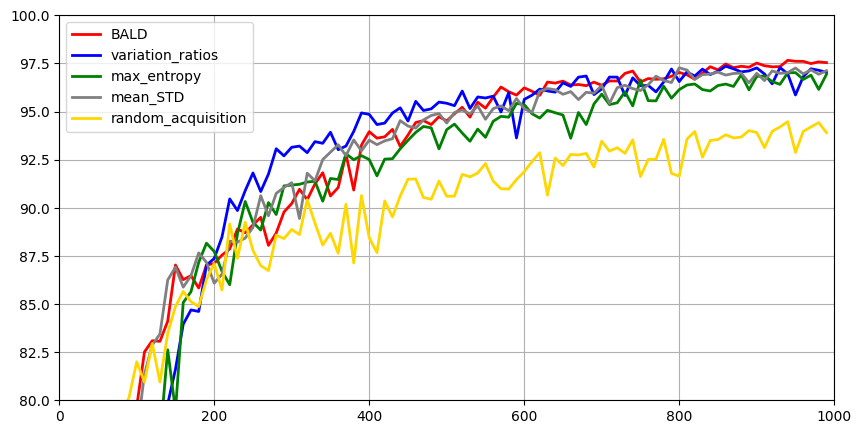

In [37]:
x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]

plt.figure(figsize=(10,5))

colors = {"BALD": "red", "variation_ratios": "blue", "max_entropy": "green", "mean_STD": "grey", "random_acquisition": "gold"}
for i, (function_name, accuracies) in enumerate(results.items()):
    plt.plot(x_values, [acc*100 for acc in accuracies], label=function_name, linewidth=2, linestyle="-", color=colors[function_name], alpha=1)

plt.ylim(80,100)
plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.savefig("acquisition_functions.png")
plt.show()

## Section 5.2 - Importance of model uncertainty

In this section, we will make a comparison of the Bayesian models to the deterministic modles for the BALD, Variation Ratios, and Max Entropy acquisition functions.


To do so, we will train one CNN for each method and compare the test accuracy with different values for the bayesianCNN flag.

In [44]:
def plot_comparison(acquisition_function_name, bayesian_accuracies, deterministic_accuracies):
    x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]

    avg_accuracy_bayesian = np.mean(bayesian_accuracies, axis=0)
    avg_accuracy_deterministic = np.mean(deterministic_accuracies, axis=0)
    std_accuracy_bayesian = np.std(bayesian_accuracies, axis=0)
    std_accuracy_deterministic = np.std(deterministic_accuracies, axis=0)

    plt.figure(figsize=(10, 6))

    plt.plot(x_values, avg_accuracy_bayesian * 100, label=acquisition_function_name, color="red")
    plt.fill_between(x_values, (avg_accuracy_bayesian - std_accuracy_bayesian) * 100, (avg_accuracy_bayesian + std_accuracy_bayesian) * 100, color="red", alpha=0.25)
    plt.plot(x_values, avg_accuracy_deterministic * 100, label=f"Deterministic {acquisition_function_name}", color="blue")
    plt.fill_between(x_values, (avg_accuracy_deterministic - std_accuracy_deterministic) * 100, (avg_accuracy_deterministic + std_accuracy_deterministic) * 100, color="blue", alpha=0.25)

    plt.legend()
    plt.grid(True)
    plt.xlim(0,1000)
    plt.ylim(80,100)
    plt.savefig(f"comparison_deterministic_{acquisition_function_name}.png")
    plt.show()

### BALD

In [ ]:
results_BALD_Deterministic = active_learning(BALD, bayesianCNN=False, average=False)
results_BALD_Bayesian = active_learning(BALD, bayesianCNN=True, average=False)

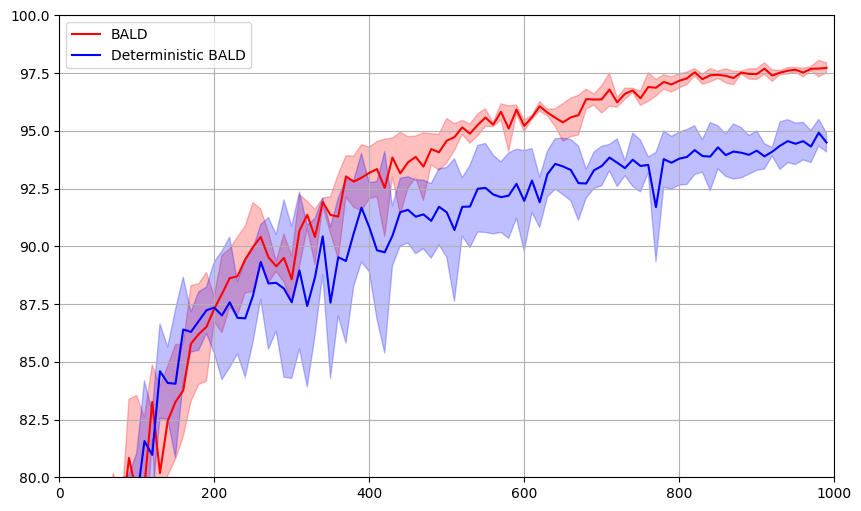

In [45]:
plot_comparison("BALD", results_BALD_Bayesian, results_BALD_Deterministic)

### Variation Ratios

In [ ]:
results_variation_ratios_Deterministic = active_learning(variation_ratios, bayesianCNN=False, average=False)
results_variation_ratios_Bayesian = active_learning(variation_ratios, bayesianCNN=True, average=False)

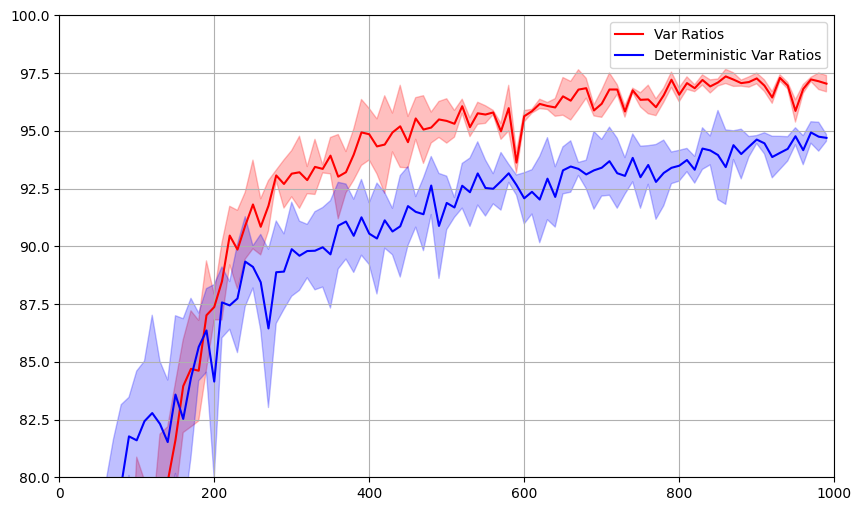

In [46]:
plot_comparison("Var Ratios", results_variation_ratios_Bayesian, results_variation_ratios_Deterministic)

### Max Entropy

In [ ]:
results_max_entropy_Deterministic = active_learning(max_entropy, bayesianCNN=False, average=False)
results_max_entropy_Bayesian = active_learning(max_entropy, bayesianCNN=True, average=False)

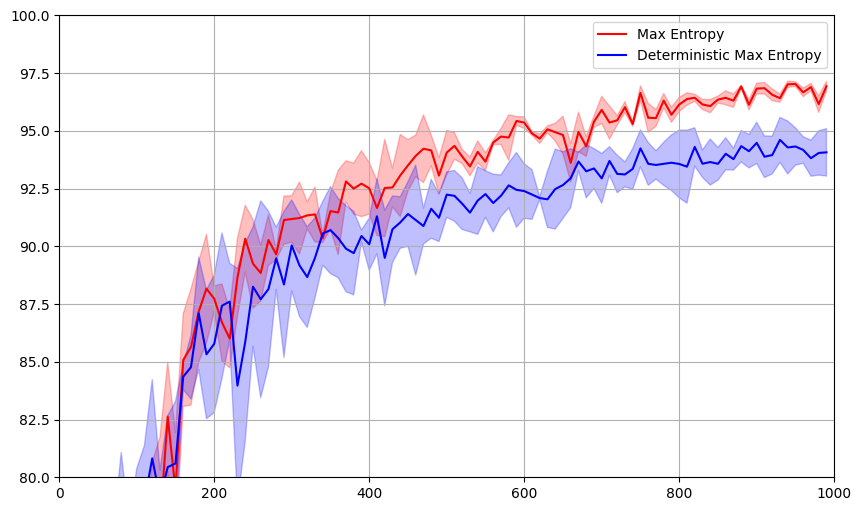

In [47]:
plot_comparison("Max Entropy", results_max_entropy_Bayesian, results_max_entropy_Deterministic)

## Memory Copy (to avoid running everything at once)

In [12]:
memory_copy_51 = {
    "BALD": np.array([0.52553333, 0.5637    , 0.58746667, 0.66856667, 0.67516667, 0.72203333, 0.72176667, 0.72706667, 0.7906    , 0.7772    ,
       0.7968    , 0.82513333, 0.83093333, 0.83063333, 0.84113333, 0.87026667, 0.86266667, 0.86473333, 0.85833333, 0.87026667,
       0.87106667, 0.8754    , 0.8786    , 0.88896667, 0.887     , 0.8911    , 0.89503333, 0.88046667, 0.8869    , 0.8978    ,
       0.9022    , 0.9096    , 0.90423333, 0.9124    , 0.9182    , 0.90613333, 0.91053333, 0.92783333, 0.9092    , 0.93256667,
       0.93953333, 0.93616667, 0.93686667, 0.94073333, 0.93186667, 0.93776667, 0.9443    , 0.9453    , 0.94323333, 0.9473    ,
       0.94513333, 0.94883333, 0.9522    , 0.9471    , 0.95483333, 0.95173333, 0.9575    , 0.96273333, 0.96026667, 0.95853333,
       0.9623    , 0.96053333, 0.9584    , 0.9653    , 0.96476667, 0.9658    , 0.96376667, 0.96403333, 0.96343333, 0.96526667,
       0.96363333, 0.9659    , 0.96583333, 0.9698    , 0.97103333, 0.9653    , 0.96713333, 0.96673333, 0.967     , 0.96833333,
       0.97033333, 0.96906667, 0.9668    , 0.97      , 0.97326667, 0.97166667, 0.9747    , 0.9728    , 0.9735    , 0.97303333,
       0.97516667, 0.9738    , 0.97323333, 0.97333333, 0.9766    , 0.9761    , 0.97606667, 0.9749    , 0.9758    , 0.9754    ]),
    "variation_ratios": np.array([0.49136667, 0.52396667, 0.5666    , 0.61443333, 0.62173333, 0.63613333, 0.6708    , 0.70253333, 0.72483333, 0.71863333,
        0.7659    , 0.76916667, 0.7655    , 0.78113333, 0.79813333, 0.81613333, 0.8395    , 0.84693333, 0.84613333, 0.87016667,
        0.87366667, 0.8848    , 0.9046    , 0.89856667, 0.9089    , 0.9181    , 0.90843333, 0.91753333, 0.93066667, 0.92696667,
        0.93143333, 0.93203333, 0.92863333, 0.93436667, 0.9335    , 0.93923333, 0.93016667, 0.93206667, 0.93966667, 0.94926667,
        0.94853333, 0.94323333, 0.944     , 0.94923333, 0.95193333, 0.94506667, 0.9553    , 0.95053333, 0.9514    , 0.9549    ,
        0.9543    , 0.95303333, 0.96063333, 0.95156667, 0.95756667, 0.95703333, 0.95796667, 0.94976667, 0.9598    , 0.93626667,
        0.9563    , 0.95846667, 0.96163333, 0.9607    , 0.96006667, 0.9649    , 0.96303333, 0.96786667, 0.96843333, 0.9588    ,
        0.9617    , 0.9679    , 0.96786667, 0.95833333, 0.9675    , 0.9634    , 0.96356667, 0.9602    , 0.96536667, 0.9721    ,
        0.9656    , 0.9706    , 0.96843333, 0.97203333, 0.9692    , 0.9709    , 0.97353333, 0.97216667, 0.9706    , 0.9711    ,
        0.97266667, 0.96953333, 0.9644    , 0.97286667, 0.96956667, 0.9586    , 0.9681    , 0.9722    , 0.97143333, 0.97036667]),
    "max_entropy": np.array([0.5131    , 0.48543333, 0.5951    , 0.60226667, 0.63873333, 0.63576667, 0.68366667, 0.67936667, 0.71126667, 0.7       ,
        0.73673333, 0.73756667, 0.7903    , 0.7798    , 0.82623333, 0.79453333, 0.85076667, 0.8564    , 0.8717    , 0.8816    ,
        0.8773    , 0.867     , 0.86003333, 0.88653333, 0.90326667, 0.89243333, 0.88843333, 0.9027    , 0.8965    , 0.91136667,
        0.9118    , 0.9122    , 0.91336667, 0.9138    , 0.9034    , 0.91523333, 0.91466667, 0.92806667, 0.92496667, 0.92706667,
        0.92506667, 0.91656667, 0.92526667, 0.9255    , 0.93063333, 0.93503333, 0.93916667, 0.94223333, 0.94153333, 0.9306    ,
        0.9406    , 0.94346667, 0.93883333, 0.93456667, 0.94086667, 0.9366    , 0.94493333, 0.9475    , 0.94706667, 0.95423333,
        0.95356667, 0.94886667, 0.9466    , 0.95063333, 0.94936667, 0.94816667, 0.93613333, 0.9495    , 0.94323333, 0.95393333,
        0.95903333, 0.9536    , 0.95453333, 0.96023333, 0.95293333, 0.9664    , 0.95563333, 0.95553333, 0.9631    , 0.95693333,
        0.96136667, 0.96376667, 0.9643    , 0.9614    , 0.96066667, 0.9635    , 0.96426667, 0.96303333, 0.96913333, 0.96126667,
        0.96826667, 0.96843333, 0.96556667, 0.96413333, 0.9701    , 0.97023333, 0.96666667, 0.9689    , 0.9615    , 0.96933333]),
    "mean_STD": np.array([0.497     , 0.6017    , 0.66293333, 0.6646    , 0.67983333, 0.71373333, 0.74743333, 0.74956667, 0.77086667, 0.78483333, 0.78176667, 0.81356667,
        0.82863333, 0.83446667, 0.86246667, 0.86913333, 0.85876667, 0.86466667, 0.87656667, 0.87166667, 0.86083333, 0.86546667, 0.88266667, 0.8821,
        0.88426667, 0.8898    , 0.90626667, 0.89583333, 0.9075    , 0.91056667, 0.91303333, 0.89443333, 0.91796667, 0.914     , 0.92503333, 0.9289,
        0.93273333, 0.92706667, 0.93523333, 0.9296    , 0.93513333, 0.9328, 0.93476667, 0.93586667, 0.94526667, 0.94243333, 0.9414    , 0.94563333,
        0.94793333, 0.94893333, 0.94403333, 0.94946667, 0.95083333, 0.94876667, 0.9529    , 0.94596667, 0.9515    , 0.95293333, 0.95043333, 0.95676667,
        0.95146667, 0.94953333, 0.9605    , 0.96193333, 0.9613    , 0.95896667, 0.96033333, 0.9562   ,  0.96      , 0.95953333, 0.96353333, 0.95423333,
        0.9624    , 0.96363333, 0.9619    , 0.96093333, 0.9639    , 0.96836667, 0.96613333, 0.96506667, 0.97273333, 0.97156667, 0.9667    , 0.96916667,
        0.96946667, 0.97046667, 0.96893333, 0.96976667, 0.96996667, 0.9649, 0.96983333, 0.96606667, 0.9711    , 0.96983333, 0.97016667, 0.9726,
        0.96956667, 0.97166667, 0.96936667, 0.97123333]),
    "random_acquisition": np.array([
        0.5605, 0.58703333, 0.63443333, 0.64893333, 0.67583333, 0.7439, 0.73723333, 0.76423333, 0.7932, 0.80133333, 0.8200, 0.8094,
        0.8295, 0.80946667, 0.83473333, 0.8487, 0.85653333, 0.85123333, 0.84866667, 0.86266667, 0.87103333, 0.85726667, 0.89156667, 0.87373333,
        0.89243333, 0.8778, 0.86993333, 0.8674, 0.8858, 0.8840, 0.88873333, 0.88606667, 0.9042, 0.89203333, 0.88063333, 0.88673333,
        0.87636667, 0.90183333, 0.87136667, 0.90636667, 0.88446667, 0.8767, 0.9035, 0.89523333, 0.90613333, 0.91483333, 0.91496667, 0.90533333,
        0.90443333, 0.91383333, 0.90596667, 0.90603333, 0.91736667, 0.91606667, 0.91803333, 0.92296667, 0.91383333, 0.90986667, 0.9097, 0.91463333,
        0.91873333, 0.92396667, 0.92863333, 0.90656667, 0.92583333, 0.92193333, 0.9277, 0.92743333, 0.92823333, 0.92116667, 0.93456667, 0.92943333,
        0.9312, 0.9283, 0.9353, 0.91626667, 0.92506667, 0.92526667, 0.93556667, 0.91786667, 0.9164, 0.9357, 0.9396, 0.92626667,
        0.93496667, 0.93543333, 0.93793333, 0.93626667, 0.93673333, 0.94006667, 0.9391, 0.93126667, 0.93976667, 0.94196667, 0.94473333, 0.92876667,
        0.93963333, 0.94203333, 0.94426667, 0.93906667])
}
results = memory_copy_51

In [13]:
memory_copy_52 = {
    "BALD_Deterministic": np.array([
        [0.5326, 0.5033, 0.6418, 0.6498, 0.7565, 0.757, 0.7761, 0.7471, 0.7277, 0.8079, 0.8094, 0.8323, 0.8297, 0.8479, 0.8587, 0.8826, 0.8929, 0.8721, 0.8737, 0.8789, 0.8816, 0.8776, 0.9074, 0.8799, 0.8854,
        0.8965, 0.9116, 0.9076, 0.913, 0.9164, 0.9223, 0.9225, 0.9236, 0.9218, 0.9249, 0.9203, 0.9261, 0.9286, 0.9354, 0.9425, 0.9356, 0.9323, 0.94, 0.9186, 0.9348, 0.9345, 0.9306, 0.9335, 0.9334, 0.9378,
        0.9392, 0.932, 0.9292, 0.9367, 0.9489, 0.9475, 0.945, 0.9425, 0.9451, 0.9478, 0.9465, 0.9473, 0.932, 0.944, 0.9481, 0.9515, 0.9517, 0.9493, 0.935, 0.9437, 0.9454, 0.9457, 0.9505, 0.9356, 0.9507,
        0.9506, 0.9392, 0.9405, 0.9517, 0.9522, 0.9533, 0.9508, 0.9549, 0.9474, 0.9543, 0.9557, 0.9515, 0.9545, 0.953, 0.95, 0.9532, 0.9467, 0.9435, 0.9575, 0.9569, 0.9559, 0.9569, 0.9473, 0.9571, 0.9492],

        [0.5909, 0.575, 0.6032, 0.5741, 0.6759, 0.7034, 0.7695, 0.7816, 0.7683, 0.7714, 0.7988, 0.8359, 0.8149, 0.8699, 0.8432, 0.834, 0.8616, 0.8655, 0.8792, 0.8798, 0.8925, 0.8997, 0.881, 0.8803, 0.8882,
        0.8891, 0.8958, 0.9003, 0.8639, 0.9004, 0.8545, 0.9033, 0.8513, 0.8754, 0.9038, 0.8641, 0.8959, 0.9074, 0.9019, 0.922, 0.8945, 0.9027, 0.9148, 0.9078, 0.9093, 0.9131, 0.916, 0.9103, 0.896, 0.9161,
        0.9131, 0.9255, 0.9224, 0.9212, 0.9226, 0.9278, 0.9185, 0.9142, 0.9208, 0.9201, 0.9194, 0.9237, 0.9199, 0.93, 0.9374, 0.9232, 0.9222, 0.9113, 0.9196, 0.9251, 0.9343, 0.9318, 0.9313, 0.9367, 0.9391,
        0.9279, 0.9357, 0.8846, 0.922, 0.9299, 0.9258, 0.9225, 0.9291, 0.9303, 0.919, 0.9339, 0.9292, 0.9255, 0.9264, 0.9295, 0.9334, 0.9349, 0.9396, 0.9332, 0.9341, 0.934, 0.9386, 0.9334, 0.9434, 0.9463],

        [0.5281, 0.6354, 0.641, 0.7527, 0.7317, 0.7607, 0.7866, 0.7614, 0.8063, 0.7749, 0.7616, 0.7788, 0.7845, 0.8199, 0.8206, 0.8049, 0.8374, 0.8512, 0.85, 0.8582, 0.8463, 0.8329, 0.8389, 0.8469, 0.8328,
        0.8503, 0.8723, 0.8438, 0.8756, 0.8282, 0.8505, 0.8428, 0.8475, 0.8625, 0.8842, 0.8424, 0.8638, 0.8449, 0.8795, 0.8856, 0.8949, 0.8598, 0.8374, 0.8873, 0.9002, 0.8997, 0.8918, 0.8976, 0.9036, 0.8974,
        0.8918, 0.8636, 0.8996, 0.8937, 0.9032, 0.9005, 0.9038, 0.9071, 0.8999, 0.9132, 0.8931, 0.9144, 0.9053, 0.9198, 0.9215, 0.929, 0.9252, 0.9214, 0.9269, 0.9299, 0.9245, 0.9377, 0.9267, 0.9292, 0.9226,
        0.9258, 0.9308, 0.9257, 0.9395, 0.9264, 0.9347, 0.9427, 0.9409, 0.9395, 0.9432, 0.9389, 0.9377, 0.943, 0.9421, 0.9393, 0.9376, 0.9352, 0.9397, 0.9398, 0.9456,0.9432, 0.941, 0.9488, 0.947, 0.9394]]),

    "BALD_Bayesian": np.array([
        [0.562, 0.5832, 0.6169, 0.673, 0.6999, 0.7503, 0.7958, 0.7921, 0.7859, 0.8385, 0.8344, 0.809, 0.8542, 0.8253, 0.8379, 0.8481, 0.8535, 0.8341, 0.836, 0.8599, 0.8794, 0.8657, 0.8852, 0.87, 0.9022,
        0.8792, 0.8961, 0.8877, 0.8883, 0.8954, 0.8717, 0.8849, 0.9061, 0.8979, 0.9185, 0.9074, 0.8921, 0.9185, 0.9129, 0.9123, 0.9196, 0.9238, 0.9267, 0.933, 0.9232, 0.9237, 0.9285, 0.9197, 0.9357, 0.935,
        0.9402, 0.9445, 0.9494, 0.9498, 0.9463, 0.9514, 0.9516, 0.9539, 0.9371, 0.9579, 0.9495, 0.9563, 0.9594, 0.957, 0.9573, 0.9459, 0.9446, 0.9477, 0.9576, 0.9666, 0.9613, 0.9716, 0.9642, 0.9679, 0.9683,
        0.9655, 0.9741, 0.9714, 0.9755, 0.9745, 0.9706, 0.9751, 0.9751, 0.9724, 0.9759, 0.9721, 0.9744, 0.9714, 0.9752, 0.9728, 0.9717, 0.9734, 0.9766, 0.9755, 0.9741, 0.9757, 0.9747, 0.9756, 0.9719, 0.9747],

        [0.5737, 0.5828, 0.6627, 0.7027, 0.7178, 0.7291, 0.7458, 0.7979, 0.775, 0.8102, 0.8097, 0.8247, 0.8282, 0.8314, 0.8443, 0.8521, 0.85, 0.8926, 0.8893, 0.8962, 0.8734, 0.9029, 0.9022, 0.9102, 0.9067,
        0.9254, 0.9212, 0.8873, 0.8937, 0.9075, 0.8945, 0.9149, 0.9143, 0.8935, 0.9215, 0.9086, 0.91, 0.9402, 0.9391, 0.9294, 0.9291, 0.9263, 0.8987, 0.932, 0.9152, 0.9345, 0.9372, 0.9293, 0.9392, 0.9353,
        0.9377, 0.942, 0.9492, 0.9433, 0.9534, 0.9551, 0.9525, 0.9583, 0.9562, 0.9577, 0.9555, 0.9547, 0.9635, 0.9566, 0.9593, 0.9649, 0.9647, 0.9683, 0.9667, 0.9632, 0.9717, 0.9741, 0.9633, 0.9676, 0.968,
        0.9669, 0.9725, 0.971, 0.969, 0.9691, 0.9758, 0.9741, 0.9773, 0.975, 0.9762, 0.9748, 0.9772, 0.9769, 0.9759, 0.9778, 0.9774, 0.9792, 0.9746, 0.9739, 0.9773, 0.9779, 0.9777, 0.9771, 0.9799, 0.9799],

        [0.4762, 0.5926, 0.6052, 0.6208, 0.6514, 0.7113, 0.7184, 0.7466, 0.7774, 0.7763, 0.7337, 0.7555, 0.8153, 0.7489, 0.791, 0.7976, 0.8092, 0.8469, 0.8606, 0.8392, 0.8659, 0.8695, 0.8712, 0.8808, 0.874,
        0.8944, 0.8949, 0.9107, 0.892, 0.882, 0.891, 0.9204, 0.9204, 0.9207, 0.9173, 0.9247, 0.9365, 0.932, 0.932, 0.9473, 0.9466, 0.9502, 0.9504, 0.9503, 0.9563, 0.9508, 0.9504, 0.9545, 0.9513, 0.9517,
        0.9592, 0.9553, 0.9558, 0.9532, 0.9579, 0.9607, 0.9538, 0.9624, 0.9595, 0.9619, 0.9514, 0.9566, 0.9589, 0.96, 0.9504, 0.9501, 0.9581, 0.9543, 0.9668, 0.9608, 0.9578, 0.9578, 0.9594, 0.9626, 0.9661,
        0.9598, 0.9602, 0.9635, 0.9689, 0.9666, 0.9685, 0.9689, 0.9736, 0.9696, 0.97, 0.9758, 0.9698, 0.9702, 0.9744, 0.9733, 0.9745, 0.9781, 0.9705, 0.9761, 0.9766, 0.9757, 0.9732, 0.9778, 0.979, 0.9771]]),

    "variation_ratios_Deterministic" : np.array([
        [0.4532, 0.5538, 0.6998, 0.7269, 0.7426, 0.7864, 0.8068, 0.8289, 0.8382, 0.8379, 0.8567, 0.8526, 0.8805, 0.8605, 0.8455, 0.8762, 0.8743, 0.8862, 0.8767, 0.8889,
        0.8968, 0.8974, 0.8856, 0.9014, 0.9201, 0.9024, 0.9115, 0.9039, 0.9192, 0.912, 0.9275, 0.9171, 0.914, 0.9201, 0.9232, 0.9289, 0.9346, 0.932, 0.9268, 0.9346,
        0.9233, 0.9327, 0.9275, 0.9202, 0.9376, 0.9406, 0.924, 0.9322, 0.9415, 0.9409, 0.9351, 0.9227, 0.9368, 0.9435, 0.9505, 0.942, 0.9341, 0.9455, 0.9368, 0.9298,
        0.9364, 0.9307, 0.9466, 0.9521, 0.9306, 0.944, 0.9491, 0.9344, 0.9369, 0.9542, 0.9503, 0.954, 0.9513, 0.9353, 0.9523, 0.9482, 0.9459, 0.942, 0.9517, 0.935,
        0.9443, 0.9408, 0.9411, 0.9516, 0.9503, 0.9584, 0.9445, 0.951, 0.9515, 0.9492, 0.9486, 0.9475, 0.9472, 0.9488, 0.9469, 0.9526, 0.9499, 0.9541, 0.9556, 0.949],

        [0.4969, 0.5322, 0.6306, 0.6599, 0.7163, 0.6954, 0.7622, 0.7676, 0.7986, 0.8187, 0.806, 0.8304, 0.8261, 0.8117, 0.82, 0.8385, 0.8327, 0.841, 0.8502, 0.8477,
        0.8323, 0.8651, 0.8607, 0.8456, 0.8856, 0.8907, 0.8612, 0.869, 0.8669, 0.8799, 0.8853, 0.8857, 0.8926, 0.879, 0.8827, 0.8851, 0.8903, 0.9075, 0.8957, 0.9077,
        0.8911, 0.8739, 0.8988, 0.8965, 0.8845, 0.9, 0.9123, 0.8937, 0.9267, 0.8911, 0.9094, 0.9151, 0.9134, 0.9184, 0.9254, 0.9137, 0.9195, 0.9222, 0.9307, 0.9204,
        0.9123, 0.91, 0.9088, 0.9088, 0.9029, 0.9194, 0.9221, 0.9297, 0.9226, 0.9131, 0.9207, 0.918, 0.9144, 0.9193, 0.9349, 0.9163, 0.9255, 0.9052, 0.9195, 0.9251,
        0.9301, 0.9302, 0.9308, 0.9301, 0.9363, 0.913, 0.9115, 0.9358, 0.9256, 0.9389, 0.9454, 0.9381, 0.9262, 0.9313, 0.9348, 0.9438, 0.9347, 0.943, 0.9404, 0.9459],

        [0.5617, 0.6179, 0.6467, 0.637, 0.7077, 0.6855, 0.7416, 0.7251, 0.7529, 0.7965, 0.7853, 0.7898, 0.7768, 0.7971, 0.7802, 0.7927, 0.7688, 0.8019, 0.8424, 0.8541,
        0.7952, 0.8646, 0.8769, 0.8852, 0.8744, 0.8801, 0.8806, 0.8204, 0.8802, 0.8752, 0.8834, 0.8849, 0.8872, 0.8951, 0.8928, 0.8755, 0.9019, 0.8926, 0.8911, 0.8953,
        0.902, 0.9035, 0.9074, 0.9025, 0.9038, 0.9116, 0.9084, 0.9157, 0.9107, 0.8944, 0.9118, 0.9126, 0.9284, 0.9083, 0.9187, 0.92, 0.9211, 0.9167, 0.9273, 0.9294,
        0.9136, 0.93, 0.9053, 0.9269, 0.9306, 0.9352, 0.9324, 0.9364, 0.9338, 0.9313, 0.931, 0.9385, 0.9292, 0.9368, 0.9276, 0.9252, 0.9342, 0.9364, 0.924, 0.9418,
        0.9302, 0.941, 0.9275, 0.9452, 0.9379, 0.9471, 0.9468, 0.9445, 0.9427, 0.9412, 0.9446, 0.9481, 0.9425, 0.9412, 0.9448, 0.9465, 0.9402, 0.9507, 0.9463, 0.9459]]),

    "variation_ratios_Bayesian" : np.array([
        [0.4419, 0.5222, 0.6008, 0.6608, 0.6603, 0.6586, 0.7139, 0.7322, 0.7304, 0.7490, 0.8240, 0.8014, 0.7856, 0.8329, 0.8249, 0.8455, 0.8622, 0.8784, 0.8762, 0.9031, 0.8810, 0.9084, 0.9184, 0.9160, 0.9288,
        0.9420, 0.9243, 0.9301, 0.9338, 0.9416, 0.9456, 0.9541, 0.9368, 0.9499, 0.9359, 0.9502, 0.9551, 0.9438, 0.9552, 0.9685, 0.9634, 0.9578, 0.9726, 0.9608, 0.9754, 0.9602, 0.9677, 0.9676, 0.9595, 0.9659,
        0.9678, 0.9610, 0.9640, 0.9571, 0.9642, 0.9623, 0.9592, 0.9546, 0.9729, 0.9327, 0.9598, 0.9591, 0.9645, 0.9627, 0.9628, 0.9738, 0.9740, 0.9706, 0.9725, 0.9618, 0.9695, 0.9762, 0.9706, 0.9598, 0.9688,
        0.9676, 0.9715, 0.9634, 0.9697, 0.9726, 0.9699, 0.9725, 0.9705, 0.9743, 0.9732, 0.9724, 0.9755, 0.9756, 0.9713, 0.9742, 0.9759, 0.9711, 0.9668, 0.9745, 0.9708, 0.9650, 0.9706, 0.9732, 0.9761, 0.9754],

        [0.4845, 0.5195, 0.5427, 0.6014, 0.6106, 0.6266, 0.6614, 0.6992, 0.7251, 0.7201, 0.7516, 0.7762, 0.7649, 0.7653, 0.8023, 0.8181, 0.8429, 0.8455, 0.8369, 0.8495, 0.8725, 0.8733, 0.8878, 0.8755, 0.9031,
        0.9173, 0.8948, 0.9190, 0.9284, 0.9211, 0.9248, 0.9214, 0.9259, 0.9209, 0.9318, 0.9354, 0.9120, 0.9303, 0.9335, 0.9451, 0.9365, 0.9286, 0.9222, 0.9410, 0.9324, 0.9337, 0.9518, 0.9318, 0.9516, 0.9488,
        0.9465, 0.9507, 0.9566, 0.9502, 0.9554, 0.9534, 0.9572, 0.9481, 0.9575, 0.9335, 0.9544, 0.9573, 0.9604, 0.9590, 0.9547, 0.9541, 0.9537, 0.9562, 0.9625, 0.9560, 0.9553, 0.9587, 0.9655, 0.9549, 0.9672,
        0.9603, 0.9564, 0.9551, 0.9627, 0.9678, 0.9634, 0.9668, 0.9678, 0.9690, 0.9668, 0.9688, 0.9692, 0.9684, 0.9688, 0.9690, 0.9716, 0.9660, 0.9609, 0.9712, 0.9676, 0.9575, 0.9660, 0.9710, 0.9674, 0.9679],

        [0.5477, 0.5302, 0.5562, 0.5811, 0.5943, 0.6232, 0.6371, 0.6763, 0.7190, 0.6868, 0.7220, 0.7299, 0.7460, 0.7451, 0.7672, 0.7848, 0.8133, 0.8169, 0.8253, 0.8578, 0.8676, 0.8727, 0.9077, 0.9042, 0.8948,
        0.8950, 0.9062, 0.9035, 0.9298, 0.9182, 0.9239, 0.9206, 0.9232, 0.9323, 0.9328, 0.9321, 0.9233, 0.9221, 0.9303, 0.9343, 0.9456, 0.9433, 0.9373, 0.9460, 0.9480, 0.9413, 0.9465, 0.9522, 0.9431, 0.9500,
        0.9485, 0.9474, 0.9613, 0.9474, 0.9531, 0.9554, 0.9574, 0.9466, 0.9490, 0.9425, 0.9547, 0.9590, 0.9600, 0.9605, 0.9628, 0.9668, 0.9614, 0.9767, 0.9703, 0.9586, 0.9603, 0.9687, 0.9675, 0.9603, 0.9665,
        0.9623, 0.9628, 0.9621, 0.9637, 0.9759, 0.9635, 0.9726, 0.9670, 0.9727, 0.9676, 0.9715, 0.9759, 0.9725, 0.9718, 0.9701, 0.9705, 0.9715, 0.9655, 0.9730, 0.9703, 0.9533, 0.9677, 0.9725, 0.9708, 0.9679]]),

    "max_entropy_Deterministic" : np.array([
        [0.4623, 0.5257, 0.5855, 0.724, 0.6918, 0.7017, 0.7151, 0.766, 0.8015, 0.7531, 0.8084, 0.8227, 0.8338, 0.7832, 0.8121, 0.8351, 0.851, 0.8562, 0.8969, 0.8857,
        0.8984, 0.9178, 0.897, 0.878, 0.8928, 0.9011, 0.9155, 0.9218, 0.9061, 0.9116, 0.9259, 0.921, 0.9139, 0.8984, 0.9195, 0.9268, 0.9196, 0.919, 0.912, 0.9009,
        0.9066, 0.9276, 0.8696, 0.927, 0.9161, 0.9271, 0.9364, 0.9097, 0.92, 0.9139, 0.9269, 0.9267, 0.9334, 0.9152, 0.9339, 0.9225, 0.9236, 0.9281, 0.9401, 0.9405,
        0.9347, 0.9346, 0.9201, 0.9334, 0.9457, 0.9431, 0.9445, 0.9385, 0.9462, 0.9452, 0.941, 0.945, 0.9297, 0.9384, 0.937, 0.9512, 0.9437, 0.9356, 0.9421, 0.9475,
        0.9519, 0.9486, 0.9531, 0.9329, 0.9403, 0.9437, 0.9488, 0.9328, 0.9519, 0.9428, 0.9548, 0.9416, 0.9454, 0.9556, 0.9542, 0.9531, 0.943, 0.9471, 0.9373, 0.9541],

        [0.4801, 0.5902, 0.6128, 0.6474, 0.7246, 0.7397, 0.7529, 0.7621, 0.7967, 0.7852, 0.7836, 0.7653, 0.8308, 0.808, 0.827, 0.8125, 0.8418, 0.8586, 0.8776, 0.8564,
        0.8469, 0.8609, 0.8746, 0.873, 0.8848, 0.9004, 0.898, 0.8834, 0.9024, 0.8995, 0.8972, 0.8866, 0.8855, 0.9143, 0.9103, 0.9125, 0.9113, 0.9038, 0.9075, 0.9057,
        0.9109, 0.921, 0.9203, 0.9023, 0.9201, 0.9202, 0.9184, 0.9178, 0.9296, 0.9241, 0.9315, 0.9322, 0.9152, 0.9244, 0.9259, 0.935, 0.931, 0.9284, 0.9208, 0.9305,
        0.9295, 0.9242, 0.9216, 0.9235, 0.9253, 0.9285, 0.9306, 0.9405, 0.9331, 0.9315, 0.9322, 0.9358, 0.942, 0.9294, 0.9421, 0.9441, 0.9407, 0.9425, 0.9425, 0.9415,
        0.9386, 0.9424, 0.9431, 0.944, 0.9463, 0.9369, 0.9395, 0.9441, 0.9429, 0.9491, 0.9464, 0.9481, 0.9452, 0.9499, 0.947, 0.9432, 0.948, 0.9392, 0.9534, 0.9387],

        [0.577, 0.5905, 0.6151, 0.6432, 0.6565, 0.6624, 0.6562, 0.6657, 0.7147, 0.6973, 0.7606, 0.7808, 0.7599, 0.7824, 0.7741, 0.7703, 0.8378, 0.8282, 0.8384, 0.8176,
        0.828, 0.8442, 0.8565, 0.7681, 0.7981, 0.846, 0.8177, 0.8393, 0.8759, 0.8393, 0.878, 0.8676, 0.8606, 0.8722, 0.8868, 0.8817, 0.8797, 0.8741, 0.8716, 0.9068,
        0.8851, 0.8904, 0.895, 0.8928, 0.8947, 0.8946, 0.8793, 0.8988, 0.8991, 0.899, 0.9087, 0.9066, 0.9066, 0.9041, 0.8996, 0.9103, 0.9016, 0.9091, 0.9182, 0.9023,
        0.9075, 0.9084, 0.9209, 0.9041, 0.9033, 0.9079, 0.9133, 0.9311, 0.9181, 0.9244, 0.915, 0.93, 0.9223, 0.9255, 0.9214, 0.9318, 0.9227, 0.9275, 0.9225, 0.9195,
        0.9164, 0.9124, 0.9328, 0.9303, 0.9228, 0.9265, 0.9318, 0.9363, 0.9352, 0.9316, 0.9331, 0.9266, 0.9279, 0.9327, 0.9271, 0.9333, 0.9341, 0.9281, 0.9305, 0.9292]
]),

    "max_entropy_Bayesian" : np.array([
        [0.4636, 0.4837, 0.6293, 0.6487, 0.6773, 0.6582, 0.7268, 0.7090, 0.7169, 0.7304, 0.7949, 0.7698, 0.8104, 0.8316, 0.8530, 0.8239, 0.8735, 0.8879, 0.9018, 0.9146, 0.8846, 0.8906, 0.8738, 0.9039, 0.9232,
        0.9164, 0.9043, 0.9153, 0.8996, 0.9260, 0.9260, 0.9343, 0.9215, 0.9293, 0.9058, 0.9262, 0.9396, 0.9398, 0.9405, 0.9463, 0.9400, 0.9311, 0.9538, 0.9370, 0.9541, 0.9502, 0.9515, 0.9593, 0.9496, 0.9416,
        0.9541, 0.9514, 0.9422, 0.9401, 0.9475, 0.9419, 0.9462, 0.9523, 0.9601, 0.9557, 0.9571, 0.9495, 0.9495, 0.9526, 0.9521, 0.9571, 0.9471, 0.9523, 0.9473, 0.9570, 0.9669, 0.9619, 0.9572, 0.9617, 0.9543,
        0.9706, 0.9636, 0.9587, 0.9674, 0.9574, 0.9657, 0.9656, 0.9664, 0.9637, 0.9647, 0.9650, 0.9662, 0.9664, 0.9698, 0.9644, 0.9715, 0.9700, 0.9680, 0.9662, 0.9713, 0.9716, 0.9691, 0.9699, 0.9662, 0.9723],

        [0.5062, 0.4810, 0.5712, 0.5892, 0.6276, 0.6263, 0.6742, 0.6760, 0.7115, 0.7015, 0.7224, 0.7446, 0.7897, 0.7640, 0.8304, 0.7965, 0.8542, 0.8549, 0.8625, 0.8610, 0.8761, 0.8555, 0.8432, 0.8635, 0.8975,
        0.8917, 0.8748, 0.9042, 0.8943, 0.9055, 0.9052, 0.9016, 0.9107, 0.9004, 0.9017, 0.9114, 0.8965, 0.9263, 0.9188, 0.9229, 0.9131, 0.9020, 0.9034, 0.9172, 0.9111, 0.9237, 0.9356, 0.9235, 0.9417, 0.9245,
        0.9328, 0.9412, 0.9348, 0.9332, 0.9387, 0.9330, 0.9442, 0.9459, 0.9448, 0.9515, 0.9517, 0.9477, 0.9453, 0.9489, 0.9440, 0.9374, 0.9268, 0.9379, 0.9373, 0.9511, 0.9526, 0.9444, 0.9522, 0.9568, 0.9526,
        0.9633, 0.9484, 0.9504, 0.9604, 0.9527, 0.9592, 0.9599, 0.9637, 0.9584, 0.9583, 0.9614, 0.9600, 0.9593, 0.9683, 0.9591, 0.9672, 0.9649, 0.9621, 0.9619, 0.9682, 0.9692, 0.9646, 0.9667, 0.9575, 0.9678],

        [0.5694, 0.4916, 0.5847, 0.5689, 0.6113, 0.6228, 0.6500, 0.6531, 0.7054, 0.6681, 0.6929, 0.6983, 0.7708, 0.7438, 0.7953, 0.7632, 0.8246, 0.8264, 0.8509, 0.8693, 0.8712, 0.8549, 0.8631, 0.8922, 0.8892,
        0.8693, 0.8862, 0.8886, 0.8956, 0.9026, 0.9042, 0.9008, 0.9079, 0.9117, 0.9027, 0.9081, 0.9078, 0.9181, 0.9156, 0.9121, 0.9222, 0.9166, 0.9185, 0.9222, 0.9267, 0.9312, 0.9303, 0.9439, 0.9332, 0.9257,
        0.9348, 0.9378, 0.9395, 0.9304, 0.9364, 0.9350, 0.9444, 0.9443, 0.9363, 0.9555, 0.9519, 0.9494, 0.9450, 0.9504, 0.9521, 0.9500, 0.9345, 0.9584, 0.9451, 0.9537, 0.9576, 0.9544, 0.9542, 0.9622, 0.9519,
        0.9653, 0.9549, 0.9574, 0.9614, 0.9607, 0.9592, 0.9657, 0.9628, 0.9621, 0.9590, 0.9641, 0.9666, 0.9634, 0.9693, 0.9603, 0.9661, 0.9704, 0.9667, 0.9642, 0.9708, 0.9699, 0.9662, 0.9702, 0.9609, 0.9678]])
}

results_BALD_Deterministic, results_BALD_Bayesian = memory_copy_52["BALD_Deterministic"], memory_copy_52["BALD_Bayesian"]
results_variation_ratios_Deterministic, results_variation_ratios_Bayesian = memory_copy_52["variation_ratios_Deterministic"], memory_copy_52["variation_ratios_Bayesian"]
results_max_entropy_Deterministic, results_max_entropy_Bayesian = memory_copy_52["max_entropy_Deterministic"], memory_copy_52["max_entropy_Bayesian"]


# Part 2 - Minimal Extension

In the minimal extension, we add a new baseline to the MNIST experiments using a hierarchical parametrised basis function regression model and using predictive variance as the acquisition function.

To achieve this, we provide two inference methods for the last weight layer:
1. Analytic inference
2. Analytic MFVI inference

At the end of the section, we compare both choices. We also detail derivations for both inference methods.

As noted in the instructions, we change the paper’s classification task to a regression task with continuous multi-dimensional outputs (so MNIST classes are vectors in $\mathbb{R}^{10}$) and use RMSE instead of accuracy.

## Defining the hierarchical parametrised basis function regression model

The first step is to define the new model. To do so, we will use our previous MNIST_CNN model, keep and freeze all of the layers except the last, and use this base as the basis function.

In [48]:
class Hierarchical_Model(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.layers = base_model.layers[:-1]

    def forward(self, x):
        return self.layers(x)

    def phi(self, loader, device=DEVICE):
        self.eval()
        all_features, all_targets = [], []

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                features = self.forward(x)
                targets = torch.nn.functional.one_hot(y, num_classes=NUM_CLASSES).float()

                all_features.append(features)
                all_targets.append(targets)

        return torch.cat(all_features, dim=0), torch.cat(all_targets, dim=0)


## First Inference Method : Analytic Inference

To perform inference for this new baseline, we extend the derivation in slides 49-56 in "Lecture Slides - slides 3-4" to multivariate outputs before implementing it. We also heavily use answers from the Q&A section from the exam as a lot of assumptions were clarified there.


### Analytic Derivation

In the paper we have to reproduce, the last layer of 10 neurons (with softmax either with cross-entropy during training or directly for acquisition steps) outputs a probability distribution for the classification task.

In the minimum extension, we now freeze all of the layers up to the penultimate one to get a feature matrix $\Phi \in \mathbb{R}^{N\times128}$ (whose rows are $\varphi(\mathbf{x}_n)^T$) and replace the last 128 to 10 fully connected layer with a 128 to 10 bayesian linear regression layer for which we want to find the posterior distribution over weights $p(W|\mathscr{D})$ and predictive distribution $p(y^*|x^*, \mathscr{D})$

We can now perform the mathematical derivations using the slides 49-56 for lectures 3-4:

#### **1. Likelihood and Prior**

Here, our goal is to derive the posterior mean and variance (c.f. slide 49) for the last layer weights $\mathbf{W} \in \mathbb{R}^{128 \times 10}$

Note $N$ the number of data samples. We start by assuming that the output classes are correlated through a covariance matrix $\Sigma \in \mathbb{R}^{10 \times 10}$.

The **likelihood** of observing a matrix $\mathbf{Y}$ given weight $\mathbf{W}$ becomes

$$p(\mathbf{Y} | \mathbf{X}, \mathbf{W}) = \mathscr{MN}_{N \times 10} (\Phi \mathbf{W}, \sigma^2\mathbf{I}_{N}, \Sigma)$$

Here, this tells us that the samples are independent but that output classes are correlated by the covariance matrix.

Then, for the **prior**, we place a Matrix Normal prior on $\mathbf{W}$:

$$p(\mathbf{W}) = \mathscr{MN}_{128 \times 10} (\mathbf{0}, s^2\mathbf{I}_{128}, \Sigma)$$

#### **2. Posterior**

We can now derive the **posterior**. Since $p(\mathbf{W} | \mathbf{X}, \mathbf{Y}) \propto p(\mathbf{Y} | \mathbf{X}, \mathbf{W}) \times p(\mathbf{W})$, the posterior also has a Matrix Normal distribution:

$$p(\mathbf{W} | \mathbf{X}, \mathbf{Y}) = \mathscr{MN}_{128 \times 10} (\mu', \Sigma', \Sigma)$$

where $\mu'$ and $\Sigma'$ are the posterior (row) covariance and mean that we need to derive as in slide 49 of the lecture slides by extending to multivariate outputs (i.e. to matrices).

Posterior (row) covariance: This models the uncertainty over features in a $128 \times 128$ matrix:
$$\Sigma'= (\sigma^{-2}\Phi^T\Phi + s^{-2}\mathbf{I}_{128})^{-1}$$

Posterior Mean:
$$\mu'= \Sigma' (\sigma^{-2}\Phi^T\mathbf{Y})$$

#### **3. Predictive**

As in slide 56 of the lecture slides, for a new input $\mathbf{x^*}$, the predictive distribution for $\mathbf{y^*}$ is:
$$p(\mathbf{y}^* | \mathbf{x}^*, \mathscr{D}) = \mathscr{MN}_{1 \times 10}(\mathbf{y^*}| \mu^*, var^*, \Sigma) = \mathscr{N}(\mu^*, \mathbf{\Sigma}^*)$$

Here:
- The predictive mean is $\mu^* = \mu'^T \varphi(\mathbf{x}^*)$
- The predictive variance (which is now rather a predictive scalar coefficient) is $var^*=\sigma^2 + \varphi(\mathbf{x}^*)^T\Sigma'\varphi(\mathbf{x}^*)$

From this, we can get the predictive covariance matrix of size $10 \times 10$ as:

$$\mathrm{Cov}(\mathbf{y^*}) = var^* \times \Sigma = (\sigma^2 + \varphi(\mathbf{x^*})^T\Sigma'\varphi(\mathbf{x^*}))\Sigma$$

This is essentially the variance for the univariate case multiplied by the feature correlation matrix.

### Acquisition Function

To combine this model within an active learning framework, we use scalar predictive variance in acquisitions. To transform the predictive covariance matrix into a scalar, we decide to take its trace. This allows us to capture the total epistemic uncertainty by aggregating marginal variances across classes. It is also more robust to singularities than tools like the determinant.

### Implementation

In [ ]:
class MNIST_Regression:
    def __init__(self, input_dim, output_dim, sigma, scalar, device=DEVICE):
        self.sigma, self.scalar = sigma, scalar
        self.Sigma_p, self.mu_p = None, None
        self.device = device

        # For the minimal extension, we assume that the covariance matrix is the identity
        # This is from the Q&A where it says that the covariance matrix should be as in the lecture (which assumes independent additive Gaussian noise and where sigma is a fixed constant)
        # It is also said in the Q&A that deriving the full covariance matrix is meant as a possible novel contribution so not for this section
        # Therefore, we simply take the trace of the identity, which is it's size
        self.trace_predictive = output_dim

    def fit(self, Phi, Y):
        Phi, Y = Phi.to(self.device), Y.to(self.device)
        I_K = torch.eye(Phi.shape[1], device=self.device)

        # Equation for the posterior row covariance from above
        self.Sigma_p = torch.linalg.inv(self.sigma**-2 * (Phi.T @ Phi) + self.scalar**-2 * I_K)

        # Equation for the posterior mean from above
        self.mu_p = self.sigma**-2 * (self.Sigma_p @ (Phi.T @ Y))

    def predict(self, Phi_star):
        Phi_star = Phi_star.to(self.device)

        # Equation for the predictive mean and variance from above
        pred_mean = Phi_star @ self.mu_p
        pred_variance = self.sigma**2 + torch.sum((Phi_star @ self.Sigma_p) * Phi_star, dim=1)

        return pred_mean, pred_variance * self.trace_predictive

def active_learning_HBF(regression_class, device=DEVICE, dynamic_batch_size=True):
    # We set sigma=1 and the scalar=1 for our likelihood and prior as reasonable starting points.
    sigma, scalar = 1., 1.
    all_rmse = []

    for run in range(TRAINING_REPEATS):
        print(f"HBF Experiment N°{run+1}/{TRAINING_REPEATS}")

        batch_size = TRAIN_BATCH_SIZE
        train_idx, val_idx, pool_idx = generate_training_indices()
        train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
        train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, shuffle_pool=False)

        run_rmse = []
        for step in range(ACQUISITION_STEPS):
            base_model = MNIST_CNN().to(device)
            base_model = train_model(base_model, train_loader, val_loader, device)
            frozen = Hierarchical_Model(base_model).to(device)
            Phi_train, Y_train = frozen.phi(train_loader, device)

            regression = regression_class(Phi_train.shape[1], 10, sigma, scalar)
            regression.fit(Phi_train, Y_train)
            features = frozen.phi(test_loader, device)[0]
            mean_preds = regression.predict(features)[0]
            test_targets = torch.cat([y for _, y in test_loader]).to(device)

            # Compute RMSE
            MSE = nn.MSELoss()(mean_preds, torch.nn.functional.one_hot(test_targets, num_classes=10).float().to(device))
            current_rmse = torch.sqrt(MSE).item()
            run_rmse.append(current_rmse)

            # Acquisition
            features = frozen.phi(pool_loader, device)[0]
            preds = regression.predict(features)[1]
            k = min(POINTS_PER_ACQUISITION, len(pool_idx))
            top_k_idx = torch.topk(preds, k).indices.cpu().numpy()

            # Update dataset
            idx_to_move = [pool_idx[i] for i in top_k_idx]
            train_idx.extend(idx_to_move)
            pool_idx = [idx for idx in pool_idx if idx not in set(idx_to_move)]

            if dynamic_batch_size and step % 25 == 0 and step > 0:
                batch_size *= 2 # We increase the batch size when the dataset increases (starts at 8 and finishes at 64)
            train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
            train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size, shuffle_pool=False)

            print(f"  Step {step}: RMSE {current_rmse:.4f}, Training set: {len(train_idx)} points")
        all_rmse.append(run_rmse)
    return np.mean(all_rmse, axis=0)

In [56]:
def plot_inference(results, inference_type: str, comparison_results=None):
    x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]
    plt.figure(figsize=(12, 6))
    plt.plot(x_values, results, label=inference_type, color="red")
    if comparison_results:
        plt.plot(x_values, comparison_results[0], label=comparison_results[1], color="blue")

    plt.legend()
    plt.grid(True)
    plt.xlabel("Acquired Images")
    plt.xlim(0,1000)
    plt.ylabel("RMSE")
    plt.savefig(f"HBF_{inference_type}.png")
    plt.show()

Analytic Experiment N°1/3
  Step 0: RMSE 0.2721, Training set: 30 points
  Step 1: RMSE 0.2692, Training set: 40 points
  Step 2: RMSE 0.2588, Training set: 50 points
  Step 3: RMSE 0.2420, Training set: 60 points
  Step 4: RMSE 0.2449, Training set: 70 points
  Step 5: RMSE 0.2434, Training set: 80 points
  Step 6: RMSE 0.2327, Training set: 90 points
  Step 7: RMSE 0.2236, Training set: 100 points
  Step 8: RMSE 0.2256, Training set: 110 points
  Step 9: RMSE 0.2280, Training set: 120 points
  Step 10: RMSE 0.2274, Training set: 130 points
  Step 11: RMSE 0.2156, Training set: 140 points
  Step 12: RMSE 0.2246, Training set: 150 points
  Step 13: RMSE 0.2280, Training set: 160 points
  Step 14: RMSE 0.2186, Training set: 170 points
  Step 15: RMSE 0.2156, Training set: 180 points
  Step 16: RMSE 0.2148, Training set: 190 points
  Step 17: RMSE 0.2145, Training set: 200 points
  Step 18: RMSE 0.2109, Training set: 210 points
  Step 19: RMSE 0.2117, Training set: 220 points
  Step 20: 

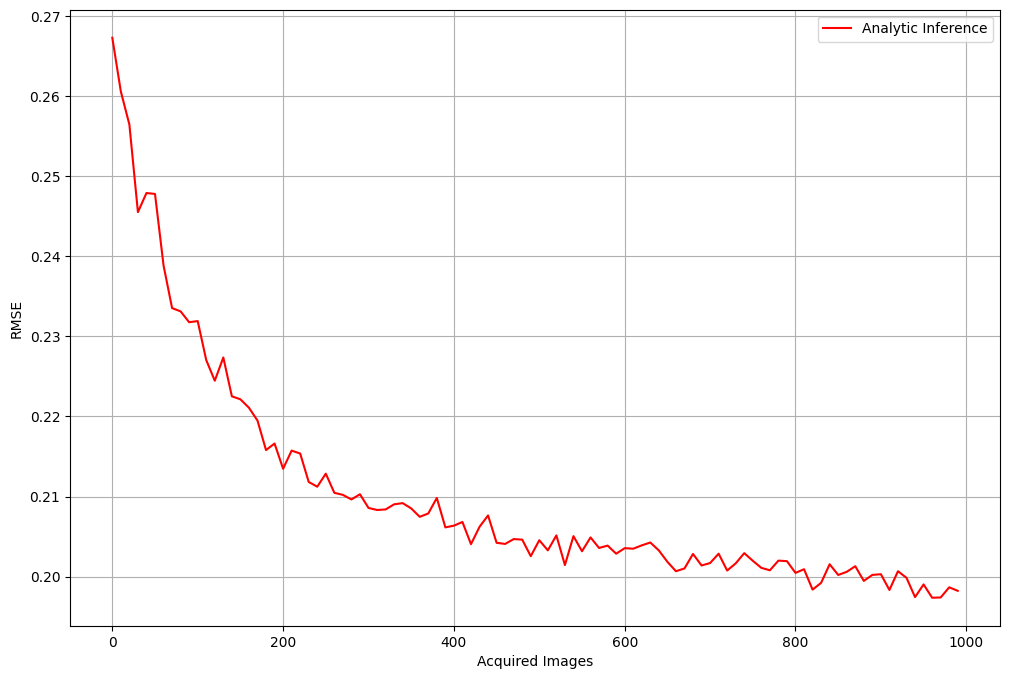

In [ ]:
results_analytic = active_learning_HBF(MNIST_Regression)

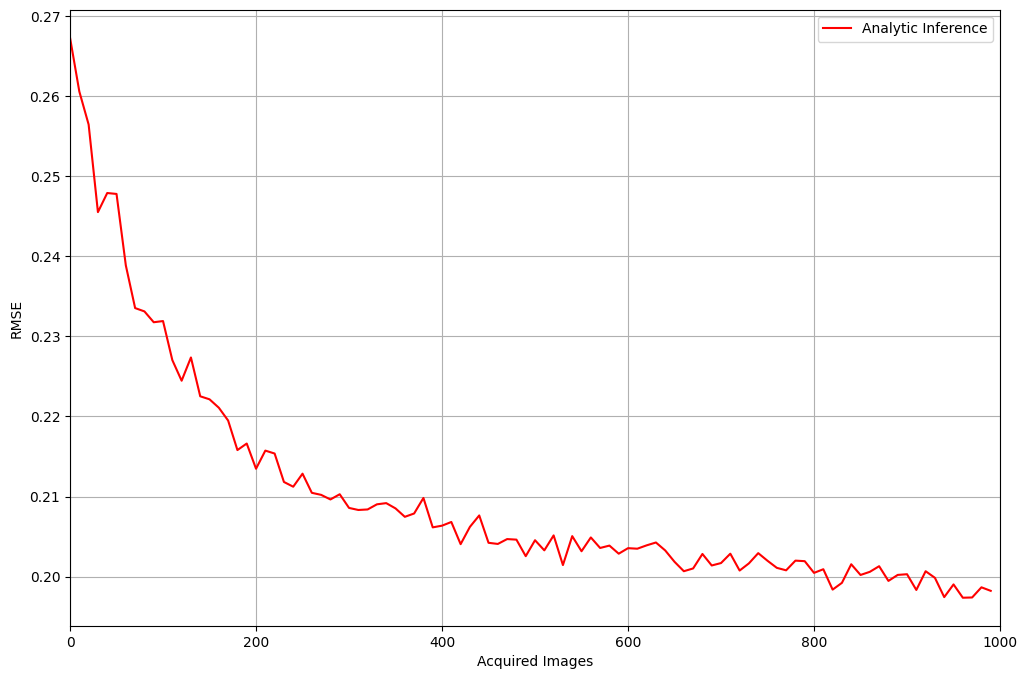

In [53]:
plot_inference(results_analytic,"Analytic Inference")

## Second Inference Method : Analytic MFVI Inference

To perform inference for this new Mean Field Variational Inference baseline, we extend the derivation in slides 59-68 in "Lecture Slides - slides 5-6" to multivariate outputs before implementing it. Once again, we use answers and assumptions from the Q&A.

### Analytic Derivation

In this section, we try to approximate the true posterior $p(\mathbf{W}|\mathscr{D})$ with a different distribution $q_{m, \sigma}$ that assumes weight independence.

As in the slides, it is defined as
$$q_{m, \sigma}(\mathbf{W})= \prod_{k=1}^{128} \prod_{d=1}^D \mathscr{N}(w_{kd} | m_{kd}, \sigma^2_{kd})$$

Now, the objective is to maximise the ELBO with respect to M and S (where the definition of M and S is taken from the slides), which has the following form
$$\mathscr{L}(\mathbf{M, S}) = \mathbb{E}_q[\ln p(\mathbf{Y | X, W})] - \mathrm{KL}(q(\mathbf{W})||p(\mathbf{W}))$$

Here, we assume taht weights are fully factorized, implying that we must ignoring class correlations $\Sigma$ to replace them with independent noise $\sigma^2 \mathbf{I}$.

#### **1. Computing the Expected log-likelihood**

As in slide 62, the expected log-likelihood is

$$\mathbb{E}_q [\ln p] = -\frac{1}{2\sigma^2} \left( \sum_{n=1}^N  ||\mathbf{y}_n - \mathbf{M}^T \phi_n||^2 + (\sum_{d=1}^D \sum_{k=1}^{128} \phi_{nk}^2 \sigma_{kd}^2 )\right) - \frac{ND}{2}\log 2 \pi \sigma^2$$

Here, the difference is that due to independence, the diagonal variance is scaled simply by the squared features. Also, since out goal is to maximise expected log likelihood, our goal can be simplified to minimizing the term in between parenthesis.

#### **2. Computing the Kullback Leiber Divergence**

As in the slides once again, we get that given the gaussian prior $p(w_{kd}) = \mathscr{N}(0, s^2)$, we have

$$\mathrm{KL}(q||p) = \sum_{k,d} \frac{1}{2} \left( s^{-2}\sigma_{kd}^2 + s^{-2}m_{kd}^2 - 1 + \ln \frac{s^2}{\sigma_{kd}^2} \right)$$

#### **3. Optimal Variational posterior**

To find the optimal parameters for the variational posterior $q$, we use the partial derivative of the ELBO $\frac{\partial \mathscr{L}}{\partial M}$ and $\frac{\partial \mathscr{L}}{\partial \sigma^2}$

Setting the partial derivative to zero and solving for the posterior mean yields an optimal solution identical to $\mu'$ in the Analytic Inference method:

$$\mathbf{M^*}= (\sigma^{-2}\Phi^T\Phi + s^{-2}\mathbf{I}_{128})^{-1} (\sigma^{-2}\Phi^T\mathbf{Y})$$

For the optimal posterior variance $\sigma^2_{kd}$, we set

$$\frac{\partial \mathscr{L}}{\partial \sigma^2_{k,d}} = -\frac{1}{2}\left( \sigma^{-2} \sum_n \phi_{nk}^2 + s^{-2} - \sigma_{k,d}^{-1} \right) = 0$$

We then solve the equation and get

$$\sigma^2_{kd} = (\sigma^{-2} \sum_{n=1}^N \phi_{nk}^2 + s^{-2})^{-1}$$


#### **4. Predictive Distribution**

As in slide 68, we get that for a new input $\mathbf{x}^*$, the predictive mean is $\mathbf{y}^* = \mathbf{M^*}^T\varphi(x^*)$. However, since the weights are independent, the variance simplifies to a sum of squares. We can thus express the predictive variance for class $d$ as:

$$\mathrm{Var}(y_d^*) = \sigma^2 + \sum_{k=1}^{128} \varphi_k(\mathbf{x}^*)^2 \sigma^2_{k,d}$$




### Implementation

In this implementation, the main difference is that now we replace the matrix inversion with a diagonal calculation. We reuse a lot of the code from above (we thus remove some comments for simplicity)

In [ ]:
class MNIST_Regression_MFVI:
    def __init__(self, input_dim, output_dim, sigma, scalar, device=DEVICE):
        self.sigma, self.scalar = sigma, scalar
        self.S_star, self.M_star = None, None
        self.device = device
        self.trace_predictive = output_dim

    def fit(self, Phi, Y):
        Phi, Y = Phi.to(self.device), Y.to(self.device)
        I_K = torch.eye(Phi.shape[1], device=self.device)

        # Optimal mean from the equation above
        A = torch.linalg.inv(self.sigma**-2 * (Phi.T @ Phi) + self.scalar**-2 * I_K)
        self.M_star = self.sigma**-2 * (A @ (Phi.T @ Y))

        # Optimal variance from the equation above
        self.S_star = 1. / (self.sigma**-2 * torch.sum(Phi**2, dim=0) + self.scalar**-2)

    def predict(self, Phi_star):
        Phi_star = Phi_star.to(self.device)
        y_star = Phi_star @ self.M_star

        # Predictive Scalar Factor s* from the equation above
        s_star = self.sigma**2 + Phi_star**2 @ self.S_star

        return y_star, s_star * self.trace_predictive

In [ ]:
results_analytic_MFVI = active_learning_HBF(MNIST_Regression_MFVI)

Experiment N°1/3
  Step 0: RMSE 0.2753, Training set: 30 points
  Step 1: RMSE 0.2742, Training set: 40 points
  Step 2: RMSE 0.2639, Training set: 50 points
  Step 3: RMSE 0.2440, Training set: 60 points
  Step 4: RMSE 0.2456, Training set: 70 points
  Step 5: RMSE 0.2423, Training set: 80 points
  Step 6: RMSE 0.2356, Training set: 90 points
  Step 7: RMSE 0.2326, Training set: 100 points
  Step 8: RMSE 0.2354, Training set: 110 points
  Step 9: RMSE 0.2321, Training set: 120 points
  Step 10: RMSE 0.2370, Training set: 130 points
  Step 11: RMSE 0.2394, Training set: 140 points
  Step 12: RMSE 0.2285, Training set: 150 points
  Step 13: RMSE 0.2324, Training set: 160 points
  Step 14: RMSE 0.2331, Training set: 170 points
  Step 15: RMSE 0.2352, Training set: 180 points
  Step 16: RMSE 0.2300, Training set: 190 points
  Step 17: RMSE 0.2339, Training set: 200 points
  Step 18: RMSE 0.2336, Training set: 210 points
  Step 19: RMSE 0.2235, Training set: 220 points
  Step 20: RMSE 0.22

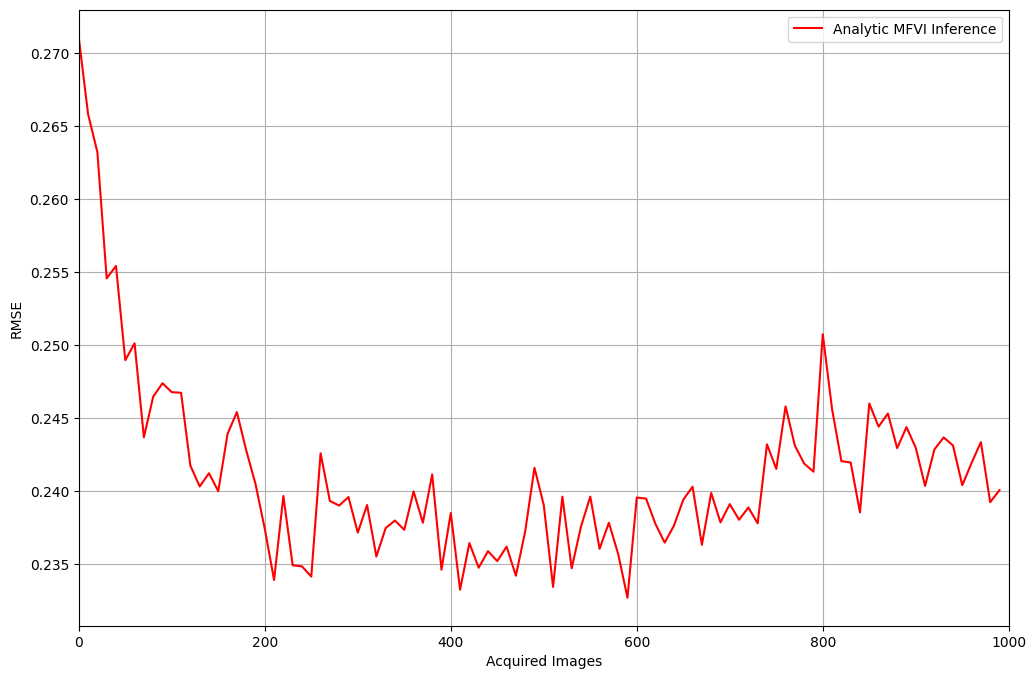

In [54]:
plot_inference(results_analytic_MFVI, "Analytic MFVI Inference")

## Comparing both methods

The main difference between analytic inference and analytic MFVI inference is the assumption of independence.
- On one side, analytic inference provides exact posterior for the weights with the full covariance matrix that captures feature correlations.
- On the other side, the Mean Field assumption forces a diagonal posterior which assumes that the epistemic uncertainties of features are independent to one another.

In practice, we see this through the MFVI's lower predictive variance, indicating high confidence, despite generating higher RMSE loss. For Active Learning, it thus appears as a worse alternative in comparison to analytic inference.

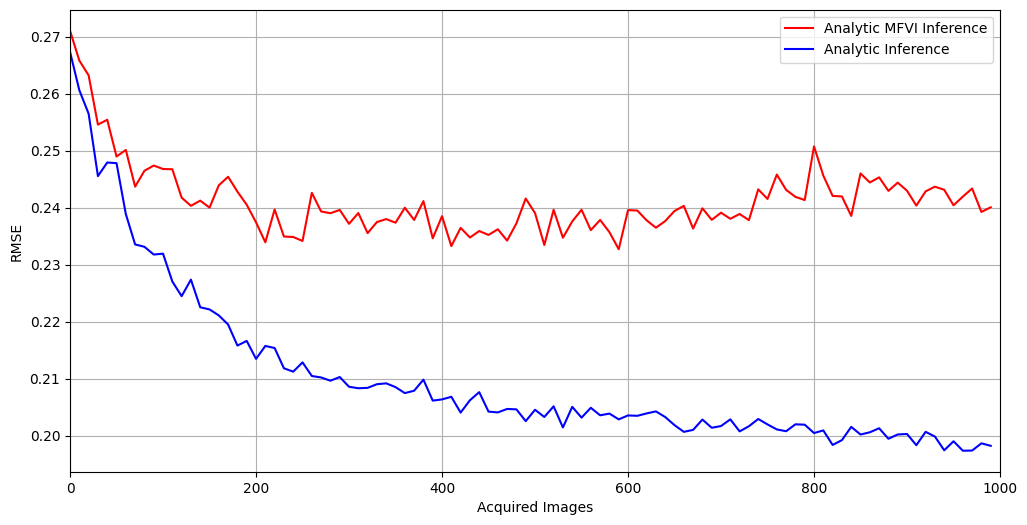

In [57]:
plot_inference(results_analytic_MFVI, "Analytic MFVI Inference", (results_analytic, "Analytic Inference"))

## Memory Copy (to avoid rerunning)

In [49]:
results_analytic = np.array([0.26732558, 0.26060352, 0.25647907, 0.2455342 , 0.24792084,
       0.24780611, 0.238876  , 0.23354487, 0.23312834, 0.23177411,
       0.2319221 , 0.22704451, 0.22446804, 0.22737166, 0.22252169,
       0.22214313, 0.22109212, 0.21949075, 0.21580268, 0.21661845,
       0.21346788, 0.2157344 , 0.21536912, 0.21181672, 0.21122315,
       0.21285232, 0.21046033, 0.21020493, 0.20963101, 0.21028141,
       0.20857331, 0.20831547, 0.20838189, 0.20902344, 0.20917214,
       0.20851191, 0.2074614 , 0.20787676, 0.20981988, 0.20614369,
       0.20635485, 0.20681604, 0.20404446, 0.20620794, 0.20763409,
       0.20421533, 0.20407201, 0.20467981, 0.20460981, 0.20254564,
       0.20453596, 0.20327025, 0.20513975, 0.20143417, 0.20504887,
       0.20316121, 0.20488545, 0.20356864, 0.20386566, 0.20285432,
       0.20354434, 0.20347698, 0.20389592, 0.20425281, 0.20325826,
       0.20183978, 0.20066414, 0.20101047, 0.20282008, 0.20138104,
       0.20168313, 0.20285468, 0.20074729, 0.20164662, 0.20292183,
       0.20196783, 0.20108485, 0.20077643, 0.20198727, 0.20191926,
       0.20045687, 0.20091219, 0.19836472, 0.19921226, 0.20153351,
       0.20019577, 0.20058746, 0.20129022, 0.19945338, 0.2002033 ,
       0.20028871, 0.19832136, 0.20066328, 0.1998369 , 0.19742806,
       0.19901317, 0.19735223, 0.19738266, 0.19865286, 0.19821192])

results_analytic_MFVI = np.array([0.27104091, 0.26580749, 0.26320872, 0.25456736, 0.25541993,
       0.24896847, 0.2501216 , 0.24368778, 0.24646705, 0.24738877,
       0.24677736, 0.24673774, 0.24175357, 0.24032407, 0.24123031,
       0.24000164, 0.24392461, 0.24541443, 0.24280632, 0.24050251,
       0.23742609, 0.23392144, 0.23967395, 0.23492954, 0.23485401,
       0.23415428, 0.24259557, 0.23932774, 0.23901941, 0.2396024 ,
       0.23716162, 0.23905488, 0.23552788, 0.23747893, 0.23799138,
       0.23735573, 0.23998634, 0.23783919, 0.24114853, 0.23462719,
       0.23850553, 0.23325938, 0.23644985, 0.23476036, 0.23589449,
       0.2352139 , 0.2362069 , 0.23421671, 0.23724383, 0.24160099,
       0.2390483 , 0.23344486, 0.23962488, 0.23472087, 0.23758008,
       0.23962878, 0.23605544, 0.23783808, 0.2356985 , 0.23270818,
       0.23956811, 0.23949056, 0.23776919, 0.23647928, 0.23764664,
       0.23941484, 0.24030609, 0.23633203, 0.23987973, 0.23786312,
       0.23911575, 0.23804354, 0.23888766, 0.23779752, 0.24320901,
       0.24152654, 0.24580463, 0.24311551, 0.2418927 , 0.24133287,
       0.25074323, 0.24561513, 0.24205814, 0.24196264, 0.23855006,
       0.24600659, 0.24441869, 0.24531753, 0.24294655, 0.24438874,
       0.24297017, 0.24036139, 0.24285626, 0.24367866, 0.24313081,
       0.24040985, 0.24193223, 0.24335626, 0.23924771, 0.24006807])

# Part 3 - Novel Extension

For the novel extension, we answer the following questions:

**Section 1: Data cleaning using uncertainty approximation**

- **Are acquisition functions robust to label noise?** (Recommeded Extension)  – *Adding label noise and analysing the results.*
- **Can MC Dropout filter mislabels in a noisy pool?** - *Computing label likelihood with the posterior to prioritise epistemic uncertainty over aleatoric uncertainty.*

**Section 2: Faster convergence with sample diversity**
- **Can we improve the initial training set and acquisitions by maximising sample diversity?**
*Reducing information overlap in the initial training set and acquisitions for faster convergence*


## Section 1: Data cleaning using uncertainty approximation

In this section, we ask ourselves two questions:
1. Are acquisition functions robust to label noise? (Recommended Extension)

2. Can MC Dropout filter mislabels in a noisy pool?

----

- To answer the first question, we add label noise to the pool of examples the acquisition score and analyse the results.
- To answer the second question, we compute the likelihood of each label in order to overcome this noise.

### Adding label noise to the pool dataset

The implementation for this part is rather straightforward. At each acquisition step, we add a probability of a mislabel and plot the results, comparing BALD—our most performant acquisition function—to the random acquisition. We also compare our results for 0% (the original results), 10%, and 20% noise.

In practice, to avoid modifying previous functions, we keep everything the same as before and only redefine the $\texttt{generate_training_indices}$ function, with a global noise variable that we will vary.


In [84]:
targets = train_val_dataset.targets.clone()

def generate_training_indices():
    # We add this safeguard to prevent noise accumulation
    train_val_dataset.targets = targets.clone()

    targets = train_val_dataset.targets.numpy()
    class_idx = [[] for _ in range(NUM_CLASSES)]
    for idx, target in enumerate(targets):
        class_idx[target].append(idx)

    train_idx = []
    remaining_idx = []
    for class_id in range(NUM_CLASSES):
        indices = class_idx[class_id]
        np.random.shuffle(indices)
        train_idx.extend(indices[:TRAIN_SET_SIZE // 10])
        remaining_idx.extend(indices[TRAIN_SET_SIZE // 10:])

    np.random.shuffle(remaining_idx)
    val_idx = remaining_idx[:VAL_SET_SIZE]
    pool_idx = remaining_idx[VAL_SET_SIZE:]

    if NOISE > 0:
        corrupt_pool_indices = np.random.choice(pool_idx, size=int(len(pool_idx) * NOISE), replace=False)
        for idx in corrupt_pool_indices:
            true_label = train_val_dataset.targets[idx].item()
            label_options = [l for l in range(NUM_CLASSES) if l != true_label]
            train_val_dataset.targets[idx] = np.random.choice(label_options)

    return train_idx, val_idx, pool_idx

def plot_noisy(noise, noisy_BALD_acc, noisy_random_acc):
    x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]
    plt.figure(figsize=(12, 8))

    avg_noisy_random_acc = np.mean(noisy_random_acc, axis=0)
    std_noisy_random_acc = np.std(noisy_random_acc, axis=0)
    plt.plot(x_values, avg_noisy_random_acc * 100, label="Random Acquisition", color="blue")
    plt.fill_between(x_values, (avg_noisy_random_acc - std_noisy_random_acc) * 100, (avg_noisy_random_acc + std_noisy_random_acc) * 100, color="blue", alpha=0.25)

    avg_noisy_BALD_acc = np.mean(noisy_BALD_acc, axis=0)
    std_noisy_BALD_acc = np.std(noisy_BALD_acc, axis=0)
    plt.plot(x_values, avg_noisy_BALD_acc * 100, label=f"BALD Acquisition", color="red")
    plt.fill_between(x_values, (avg_noisy_BALD_acc - std_noisy_BALD_acc) * 100, (avg_noisy_BALD_acc + std_noisy_BALD_acc) * 100, color="red", alpha=0.25)

    plt.legend()
    plt.title(f"Comparison between random acquisition and BALD with {noise*100}% label noise ")
    plt.grid(True)
    plt.xlim(0,1000)
    plt.ylim(70,100)
    plt.savefig(f"comparison_{noise*100}%_noisy_labels.png")
    plt.show()

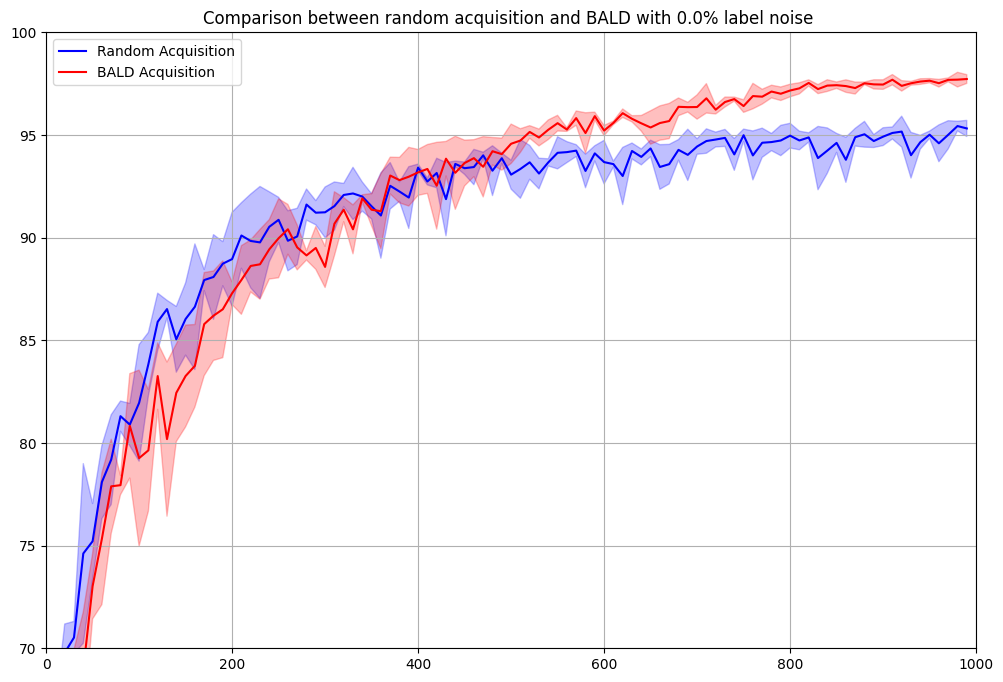

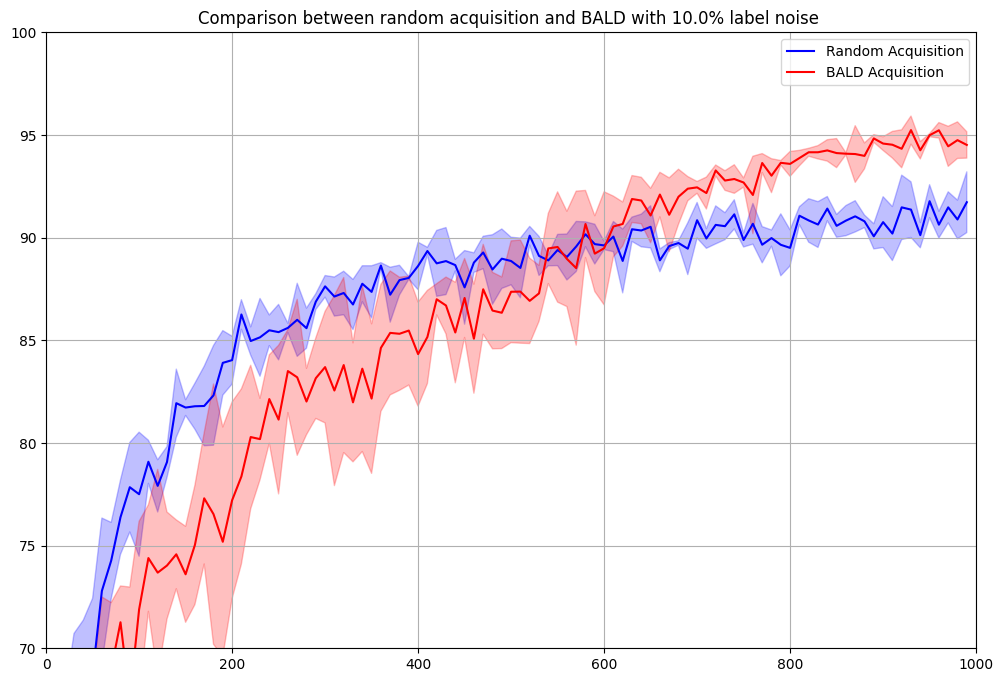

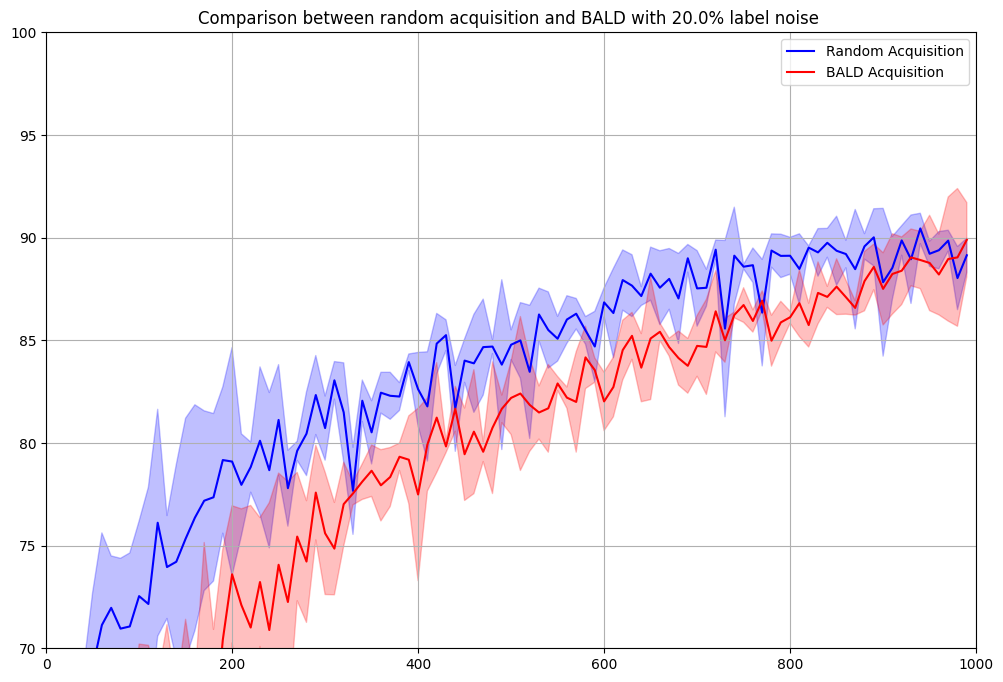

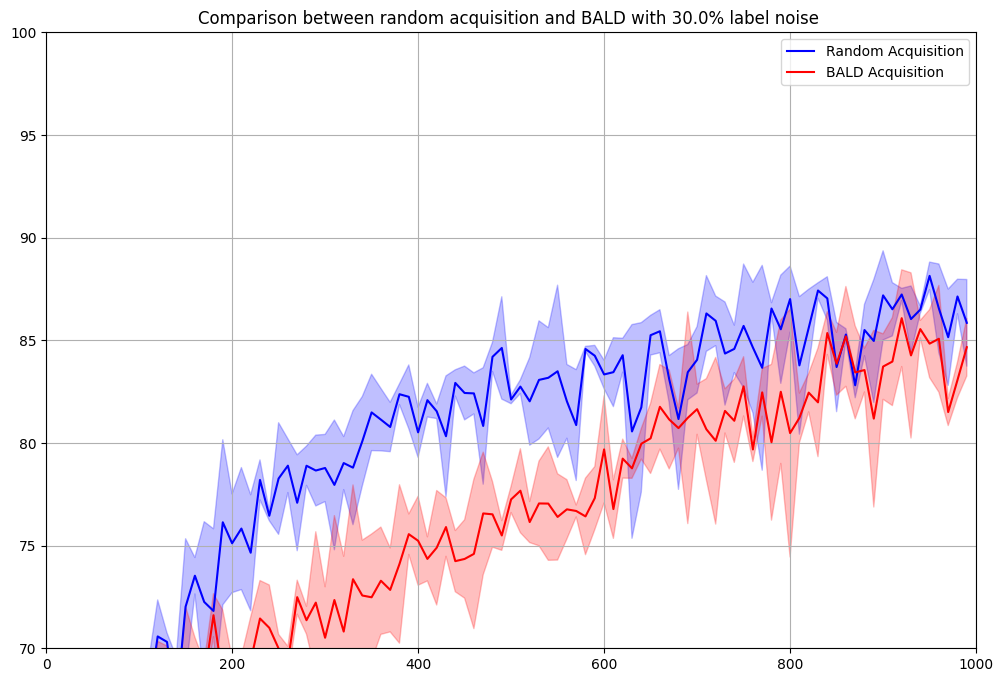

In [85]:
noise_list = [0.0, 0.1, 0.2, 0.3]
noisy_BALD_accuracies = []
random_accuracies = []
for i, eps in enumerate(noise_list):
    NOISE = eps
    noisy_BALD_accuracies.append(active_learning(BALD, bayesianCNN=True, average=False, shuffle_pool=False))
    random_accuracies.append(active_learning(random_acquisition, bayesianCNN=True, average=False, shuffle_pool=False))
    plot_noisy(NOISE, noisy_BALD_accuracies[i], random_accuracies[i])


### Computing label likelihood to filter out noise

In this section, we create a function that will compute the probability that an input has the label it is assigned in the (noisy) pool. If that probability is too low (below a given threshold that we optimise with a grid search), then we consider that the label is probably incorrect and disregard that element for acquisition.

We also have to adjust the active learning function to take that new constraint into account. After this, we simply compare the BALD function without noise, with 20% noise but without correction, and with 20% noise but with filtering.

In [81]:
def get_mc_predictions_with_label_likelihood(model, loader, device=DEVICE):
    model.train()
    conv_layers = model.layers[:5]
    fc_block = model.layers[5:]

    all_likelihood_scores = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            batch_size = x.size(0)
            features = conv_layers(x)

            features_expanded = features.unsqueeze(0).expand(MC_SAMPLES, -1, -1, -1, -1)
            features_flattened = features_expanded.reshape(-1, *features.shape[1:])
            logits = fc_block(features_flattened)
            probs = torch.softmax(logits, dim=1)
            mc_probs = probs.view(MC_SAMPLES, batch_size, -1)
            mean_probs = mc_probs.mean(dim=0)
            sample_likelihood = mean_probs.gather(1, y.view(-1, 1)).squeeze()
            all_likelihood_scores.append(sample_likelihood)
    return torch.cat(all_likelihood_scores)

def active_learning_noise_filter(acquisition_function, dynamic_batch_size=True, fixed_ft=-1, verbose=False):
    all_accuracies = []
    total_samples_rejected = 0
    for run in range(TRAINING_REPEATS):
        print(f"Experiment N°{run+1}/{TRAINING_REPEATS} - {NOISE*100}% label noise")
        batch_size = TRAIN_BATCH_SIZE
        train_idx, val_idx, pool_idx = generate_training_indices()
        train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
        train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size, shuffle_pool=False)

        model = MNIST_CNN()
        model = train_model(model, train_loader, val_loader)

        run_accuracies = []
        for step in range(ACQUISITION_STEPS):
            samples_rejected = 0
            all_preds = get_predictions(model, pool_loader)
            scores = acquisition_function(all_preds) + torch.rand_like(scores)*1e-8

            # New filtering logic
            likelihood_scores = get_mc_predictions_with_label_likelihood(model, pool_loader)
            sorted_indices = torch.argsort(scores, descending=True).cpu().numpy()

            idx_to_move = []
            for i in sorted_indices:
                if len(idx_to_move) >= POINTS_PER_ACQUISITION:
                    break

                filter_threshold = 0.05 + 0.15*step/ACQUISITION_STEPS if fixed_ft == -1 else fixed_ft
                if likelihood_scores[i] >= filter_threshold:
                    idx_to_move.append(pool_idx[i])
                else:
                    samples_rejected += 1
                    total_samples_rejected += 1

            set_idx_to_move = set(idx_to_move)
            train_idx.extend(idx_to_move)
            pool_idx = [idx for idx in pool_idx if idx not in set_idx_to_move]

            if dynamic_batch_size and step % 25 == 0 and step > 0:
                batch_size *= 2
            train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
            train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size)

            model = MNIST_CNN()
            model = train_model(model, train_loader, val_loader)
            accuracy = test_model(model, test_loader)
            run_accuracies.append(accuracy)
            print(f"  Step {step}: Accuracy {accuracy*100:.2f}%, Training set: {len(train_idx)} points, Rejections: {samples_rejected} samples")
        all_accuracies.append(run_accuracies)
    print(f"Average number of rejections per acquisition step: {total_samples_rejected/(ACQUISITION_STEPS*TRAINING_REPEATS)}")
    return all_accuracies

def plot_filter_comparison(acquisition_function_name, noise_level, no_noise_acc, noise_acc, noise_filter_acc):
    x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]

    avg_acc_no_noise = np.mean(no_noise_acc, axis=0)
    avg_acc_noise = np.mean(noise_acc, axis=0)
    avg_acc_noise_filter = np.mean(noise_filter_acc, axis=0)
    std_acc_no_noise = np.std(no_noise_acc, axis=0)
    std_acc_noise = np.std(noise_acc, axis=0)
    std_acc_noise_filter = np.std(noise_filter_acc, axis=0)

    plt.figure(figsize=(12, 8))

    plt.plot(x_values, avg_acc_no_noise * 100, label=acquisition_function_name, color="red")
    plt.fill_between(x_values, (avg_acc_no_noise - std_acc_no_noise) * 100, (avg_acc_no_noise + std_acc_no_noise) * 100, color="red", alpha=0.25)
    if NOISE > 0:
        plt.plot(x_values, avg_acc_noise * 100, label=f"{acquisition_function_name} with {noise_level*100}% label noise", color="blue")
        plt.fill_between(x_values, (avg_acc_noise - std_acc_noise) * 100, (avg_acc_noise + std_acc_noise) * 100, color="blue", alpha=0.25)
    plt.plot(x_values, avg_acc_noise_filter * 100, label=f"{acquisition_function_name} with {noise_level*100}% label noise and noise filter", color="green")
    plt.fill_between(x_values, (avg_acc_noise_filter - std_acc_noise_filter) * 100, (avg_acc_noise_filter + std_acc_noise_filter) * 100, color="green", alpha=0.25)

    plt.legend()
    plt.grid(True)
    plt.xlim(0,1000)
    plt.ylim(70,100)
    plt.savefig(f"comparison_noise_filter_{acquisition_function_name}.png")
    plt.show()

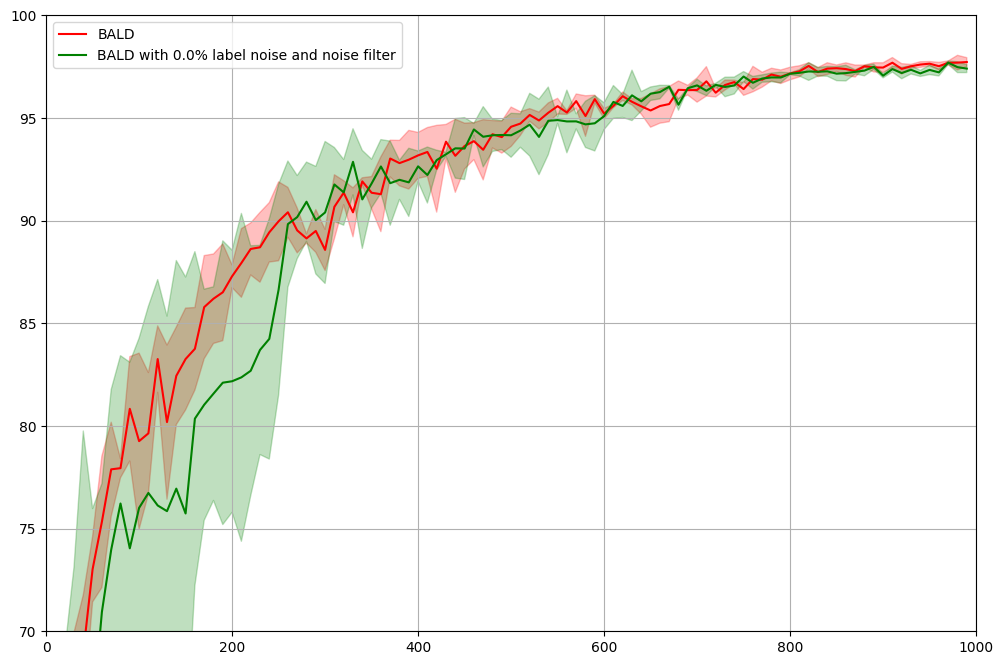

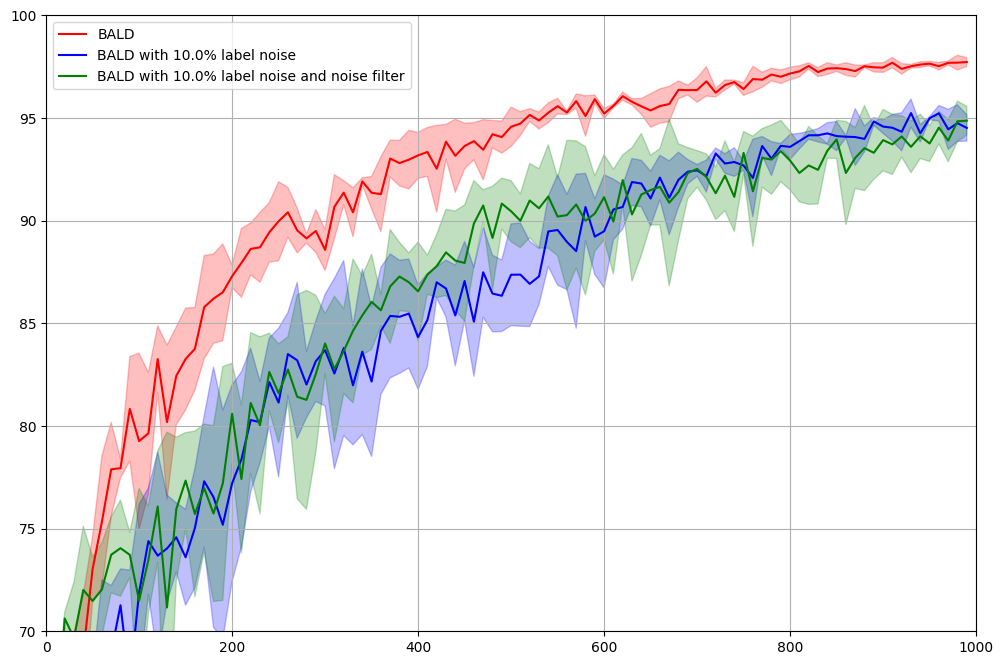

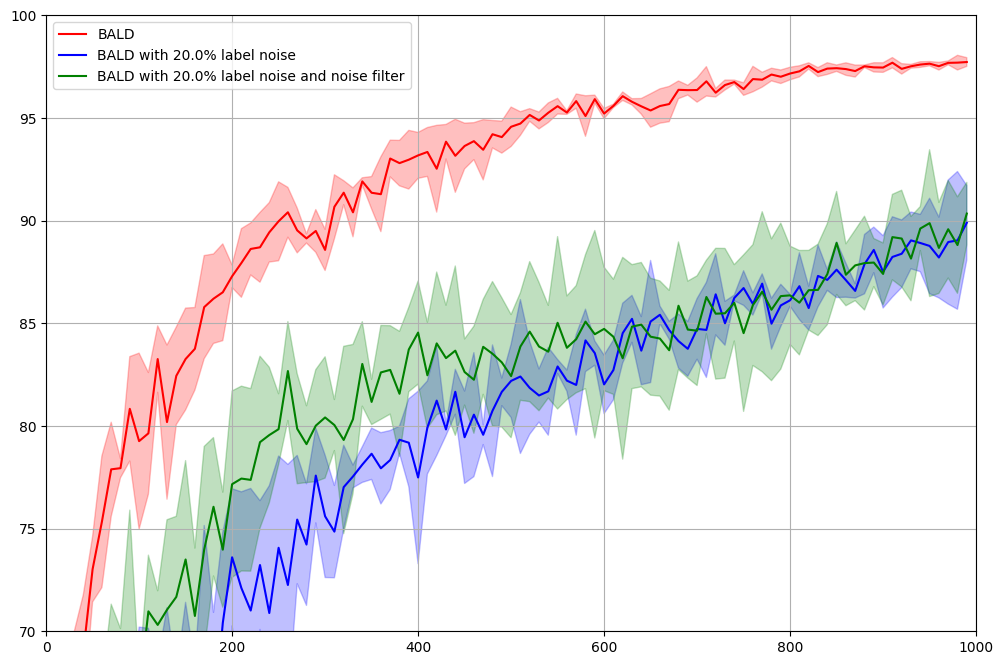

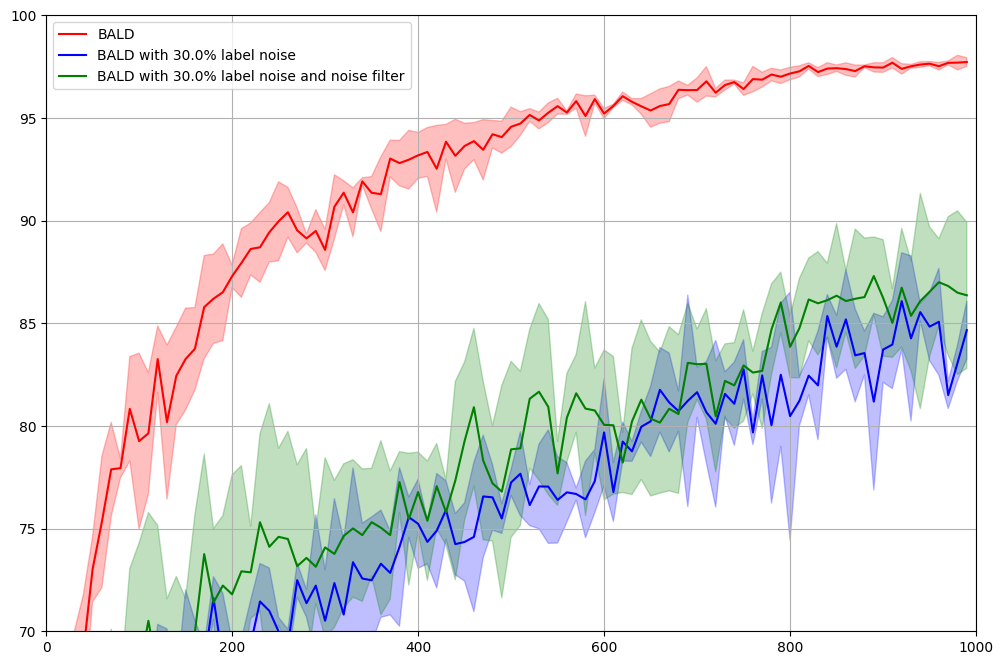

In [82]:
noise_list = [0.0, 0.1, 0.2, 0.3]
filtered_noisy_BALD_accuracies = []
for i, eps in enumerate(noise_list):
    NOISE = eps
    filtered_noisy_BALD_accuracies.append(active_learning_noise_filter(BALD))
    plot_filter_comparison("BALD", NOISE, results_BALD_Bayesian, noisy_BALD_accuracies[i], filtered_noisy_BALD_accuracies[i])

In the above, the average number of samples rejected per acquisition step is:
- 0.39 for 0% label noise (0.39 over optimal)
- 1.47 for 10% label noise (+47% over optimal)
- 2.98 for 20% label noise (+49% over optimal)
- 4.96 for 30% label noise (+65% over optimal)

Our results also indicate that the model filters too often, potentially losing out on information. This suggests that fine-tuning the filter threshold could potentially yield even better results.

---

We also made a sanity check of our technique. If we use it on the pool set without noise, it is likely that the rejected samples would have provided useful data. We should therefore expect to see low rejection rates and similar/slightly worse performance.

This is confirmed in our experiments, especially at the start. Since with 0% noise, the most informative samples are discarded (despite the increasing threshold), the performance at the start is worse. Nonetheless, after seeing enough samples, this performance loss evens out.

### Comparing an increasing filter threshold to other alternatives

We can compare this choice to a fixed threshold with varying levels (in our case 10% and 25%). As expected, we get that our increasing filter threshold offers the best performance.

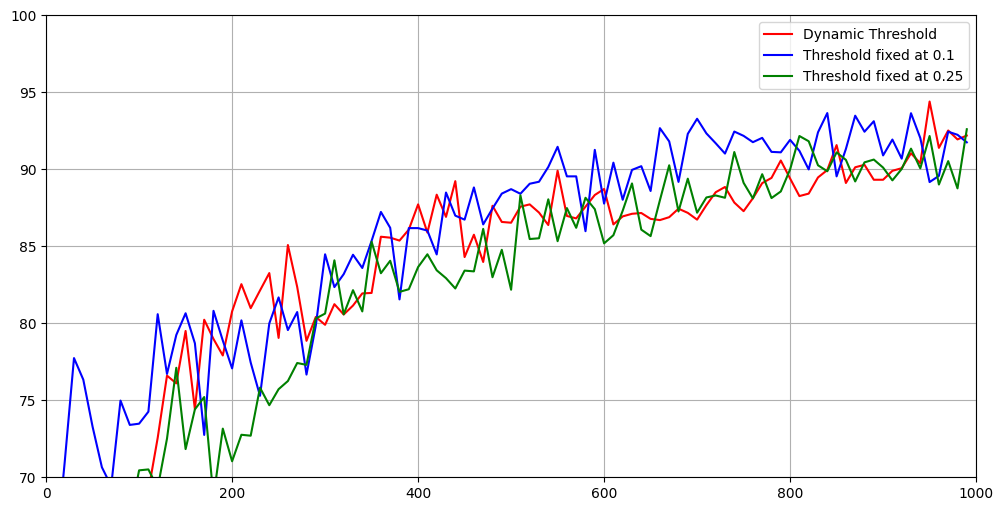

In [70]:
def plot_filter_threshold_comparison(acquisition_function_name, noise_level, dynamic_acc, fixed_10_acc, fixed_25_acc):
    x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]
    plt.figure(figsize=(12, 6))


    plt.plot(x_values, dynamic_acc * 100, label=f"Dynamic Threshold", color="red")
    plt.plot(x_values, fixed_10_acc * 100, label=f"Threshold fixed at 0.1", color="blue")
    plt.plot(x_values, fixed_25_acc * 100, label=f"Threshold fixed at 0.25", color="green")

    plt.legend()
    plt.grid(True)
    plt.xlim(0,1000)
    plt.ylim(70,100)
    plt.savefig(f"comparison_noise_filter_threshold_{acquisition_function_name}.png")
    plt.show()

TRAINING_REPEATS = 1
NOISE = 0.2
fixed_10_acc = active_learning_noise_filter(BALD, fixed_ft = 0.1)
fixed_25_acc = active_learning_noise_filter(BALD, fixed_ft = 0.25)
plot_filter_threshold_comparison("BALD", NOISE, filtered_noisy_BALD_accuracies[2][2], fixed_10_acc, fixed_25_acc)

- For the fixed threshold at 0.1, we have an average sample rejection rate of 3.18 (59% over optimal)
- For the fixed threshold at 0.25, we have an average sample rejection rate of 5.1 (155% over optimal)

Furthermore, even if it is very close, we see a performance gain from the dynamic threshold. It therefore confirms our previous results and justifies our use of a dynamic threshold. We also see that at the start the high filter threshold is prohibitive to performance, indicating that an increasing threshold is likely a good option

### Analytical Analysis and Derivation

In this section, to support our experiment, we can also give a mathematical grounding to our work.

Indeed, we seek to acquire points that will maximise BALD while avoiding noise. Formally, given $y_{pool}$ the noisy label from the oracle, we rely on the posterior predictive $p(y|x, \mathscr{D}_{train})$ approximated by MC Dropout to define our trust set defined as

$$\{ x \in \mathscr{D}_{pool} | p(y=y_{pool} | x, \mathscr{D}_{train}) \geq \tau \}$$

where the threshold can be learned empirically using a grid search.

Choosing the inputs within this set that maximise BALD ensures that we are giving the priority to elements that have high epistemic uncertainty but that are not disproportionally affected by aleatoric uncertainty, since mislabeled points will typically have high BALD but low consistency in predictions-allowing us to often filter them out.

### Memory Copy (to avoid rerunning all at once)

In [65]:
noisy_BALD_accuracies = [np.array([[0.562 , 0.5832, 0.6169, 0.673 , 0.6999, 0.7503, 0.7958, 0.7921,
         0.7859, 0.8385, 0.8344, 0.809 , 0.8542, 0.8253, 0.8379, 0.8481,
         0.8535, 0.8341, 0.836 , 0.8599, 0.8794, 0.8657, 0.8852, 0.87  ,
         0.9022, 0.8792, 0.8961, 0.8877, 0.8883, 0.8954, 0.8717, 0.8849,
         0.9061, 0.8979, 0.9185, 0.9074, 0.8921, 0.9185, 0.9129, 0.9123,
         0.9196, 0.9238, 0.9267, 0.933 , 0.9232, 0.9237, 0.9285, 0.9197,
         0.9357, 0.935 , 0.9402, 0.9445, 0.9494, 0.9498, 0.9463, 0.9514,
         0.9516, 0.9539, 0.9371, 0.9579, 0.9495, 0.9563, 0.9594, 0.957 ,
         0.9573, 0.9459, 0.9446, 0.9477, 0.9576, 0.9666, 0.9613, 0.9716,
         0.9642, 0.9679, 0.9683, 0.9655, 0.9741, 0.9714, 0.9755, 0.9745,
         0.9706, 0.9751, 0.9751, 0.9724, 0.9759, 0.9721, 0.9744, 0.9714,
         0.9752, 0.9728, 0.9717, 0.9734, 0.9766, 0.9755, 0.9741, 0.9757,
         0.9747, 0.9756, 0.9719, 0.9747],
        [0.5737, 0.5828, 0.6627, 0.7027, 0.7178, 0.7291, 0.7458, 0.7979,
         0.775 , 0.8102, 0.8097, 0.8247, 0.8282, 0.8314, 0.8443, 0.8521,
         0.85  , 0.8926, 0.8893, 0.8962, 0.8734, 0.9029, 0.9022, 0.9102,
         0.9067, 0.9254, 0.9212, 0.8873, 0.8937, 0.9075, 0.8945, 0.9149,
         0.9143, 0.8935, 0.9215, 0.9086, 0.91  , 0.9402, 0.9391, 0.9294,
         0.9291, 0.9263, 0.8987, 0.932 , 0.9152, 0.9345, 0.9372, 0.9293,
         0.9392, 0.9353, 0.9377, 0.942 , 0.9492, 0.9433, 0.9534, 0.9551,
         0.9525, 0.9583, 0.9562, 0.9577, 0.9555, 0.9547, 0.9635, 0.9566,
         0.9593, 0.9649, 0.9647, 0.9683, 0.9667, 0.9632, 0.9717, 0.9741,
         0.9633, 0.9676, 0.968 , 0.9669, 0.9725, 0.971 , 0.969 , 0.9691,
         0.9758, 0.9741, 0.9773, 0.975 , 0.9762, 0.9748, 0.9772, 0.9769,
         0.9759, 0.9778, 0.9774, 0.9792, 0.9746, 0.9739, 0.9773, 0.9779,
         0.9777, 0.9771, 0.9799, 0.9799],
        [0.4762, 0.5926, 0.6052, 0.6208, 0.6514, 0.7113, 0.7184, 0.7466,
         0.7774, 0.7763, 0.7337, 0.7555, 0.8153, 0.7489, 0.791 , 0.7976,
         0.8092, 0.8469, 0.8606, 0.8392, 0.8659, 0.8695, 0.8712, 0.8808,
         0.874 , 0.8944, 0.8949, 0.9107, 0.892 , 0.882 , 0.891 , 0.9204,
         0.9204, 0.9207, 0.9173, 0.9247, 0.9365, 0.932 , 0.932 , 0.9473,
         0.9466, 0.9502, 0.9504, 0.9503, 0.9563, 0.9508, 0.9504, 0.9545,
         0.9513, 0.9517, 0.9592, 0.9553, 0.9558, 0.9532, 0.9579, 0.9607,
         0.9538, 0.9624, 0.9595, 0.9619, 0.9514, 0.9566, 0.9589, 0.96  ,
         0.9504, 0.9501, 0.9581, 0.9543, 0.9668, 0.9608, 0.9578, 0.9578,
         0.9594, 0.9626, 0.9661, 0.9598, 0.9602, 0.9635, 0.9689, 0.9666,
         0.9685, 0.9689, 0.9736, 0.9696, 0.97  , 0.9758, 0.9698, 0.9702,
         0.9744, 0.9733, 0.9745, 0.9781, 0.9705, 0.9761, 0.9766, 0.9757,
         0.9732, 0.9778, 0.979 , 0.9771]]),

        [[0.5697, 0.5305, 0.5108, 0.6116, 0.6534, 0.6948, 0.6438, 0.7157, 0.6879, 0.6415, 0.7232, 0.7126, 0.6916, 0.7340, 0.7406, 0.7218, 0.7246, 0.7522, 0.6948, 0.7104, 0.7142, 0.7578, 0.7687, 0.7924, 0.8367,
         0.8429, 0.8546, 0.8646, 0.8193, 0.8295, 0.8455, 0.7883, 0.8233, 0.7965, 0.8440, 0.7954, 0.8348, 0.8301, 0.8349, 0.8317, 0.8220, 0.8284, 0.8683, 0.8515, 0.8528, 0.8697, 0.8370, 0.8590, 0.8638, 0.8543,
         0.8624, 0.8656, 0.8552, 0.8808, 0.9097, 0.9130, 0.9062, 0.8924, 0.9025, 0.8916, 0.8992, 0.9144, 0.9079, 0.9143, 0.9196, 0.9059, 0.9232, 0.9176, 0.9237, 0.9284, 0.9250, 0.9145, 0.9315, 0.9298, 0.9330,
         0.9273, 0.8941, 0.9428, 0.9270, 0.9356, 0.9382, 0.9405, 0.9443, 0.9381, 0.9417, 0.9319, 0.9416, 0.9222, 0.9340, 0.9463, 0.9411, 0.9368, 0.9304, 0.9574, 0.9386, 0.9491, 0.9474, 0.9307, 0.9382, 0.9363],
        [0.6535, 0.6495, 0.6551, 0.6586, 0.6572, 0.6309, 0.6542, 0.6440, 0.7280, 0.6313, 0.6643, 0.7431, 0.7119, 0.7120, 0.7283, 0.7173, 0.7354, 0.7487, 0.7527, 0.7143, 0.7705, 0.7494, 0.7890, 0.7837, 0.7909,
         0.7607, 0.8072, 0.7787, 0.8008, 0.8086, 0.8002, 0.7975, 0.7946, 0.8022, 0.7833, 0.7963, 0.8155, 0.8345, 0.8325, 0.8406, 0.8289, 0.8440, 0.8616, 0.8642, 0.8243, 0.8475, 0.8274, 0.8597, 0.8420, 0.8481,
         0.8505, 0.8478, 0.8538, 0.8536, 0.8708, 0.8575, 0.8568, 0.8360, 0.8890, 0.8699, 0.8591, 0.8846, 0.8929, 0.9076, 0.9035, 0.8975, 0.9067, 0.8866, 0.9019, 0.9155, 0.9207, 0.9181, 0.9302, 0.9212, 0.9187,
         0.9239, 0.9338, 0.9324, 0.9220, 0.9380, 0.9276, 0.9335, 0.9402, 0.9407, 0.9365, 0.9425, 0.9404, 0.9554, 0.9486, 0.9508, 0.9484, 0.9526, 0.9518, 0.9570, 0.9406, 0.9509, 0.9566, 0.9522, 0.9595, 0.9514],
        [0.5854, 0.5705, 0.6021, 0.6669, 0.6471, 0.6311, 0.7432, 0.7097, 0.7221, 0.7523, 0.7692, 0.7761, 0.8070, 0.7749, 0.7684, 0.7690, 0.7909, 0.8182, 0.8485, 0.8309, 0.8315, 0.8438, 0.8509, 0.8295, 0.8365,
         0.8305, 0.8432, 0.8526, 0.8404, 0.8565, 0.8651, 0.8908, 0.8959, 0.8606, 0.8812, 0.8731, 0.8886, 0.8962, 0.8921, 0.8919, 0.8789, 0.8824, 0.8800, 0.8851, 0.8843, 0.8946, 0.8879, 0.9058, 0.8876, 0.8878,
         0.9080, 0.9077, 0.8986, 0.8841, 0.9037, 0.9158, 0.9059, 0.9270, 0.9284, 0.9151, 0.9261, 0.9173, 0.9191, 0.9345, 0.9311, 0.9289, 0.9330, 0.9292, 0.9341, 0.9276, 0.9277, 0.9325, 0.9364, 0.9324, 0.9339,
         0.9293, 0.9344, 0.9338, 0.9415, 0.9357, 0.9419, 0.9422, 0.9402, 0.9459, 0.9492, 0.9491, 0.9406, 0.9445, 0.9368, 0.9478, 0.9479, 0.9463, 0.9476, 0.9427, 0.9484, 0.9496, 0.9528, 0.9505, 0.9447, 0.9477]],

        [[0.5732, 0.6104, 0.6313, 0.5836, 0.6236, 0.6556, 0.6996, 0.6459, 0.6346, 0.6485, 0.7018, 0.6427, 0.6008, 0.6559, 0.6235, 0.6773, 0.6694, 0.7038, 0.6885, 0.6893, 0.7552, 0.7464, 0.6687, 0.7479, 0.7340,
         0.7690, 0.7547, 0.7324, 0.7131, 0.7906, 0.7280, 0.7470, 0.7417, 0.7680, 0.7869, 0.7998, 0.7551, 0.7656, 0.7848, 0.7958, 0.7938, 0.8144, 0.8037, 0.7996, 0.8091, 0.7974, 0.8482, 0.7958, 0.8511, 0.8158,
         0.8384, 0.8672, 0.8505, 0.8306, 0.8406, 0.8299, 0.8171, 0.8544, 0.8627, 0.8438, 0.8377, 0.8439, 0.8598, 0.8682, 0.8483, 0.8786, 0.8495, 0.8411, 0.8597, 0.8526, 0.8681, 0.8754, 0.8854, 0.8441, 0.8604,
         0.8751, 0.8521, 0.8627, 0.8356, 0.8524, 0.8636, 0.8851, 0.8577, 0.8866, 0.8766, 0.8856, 0.8784, 0.8633, 0.8880, 0.9005, 0.8784, 0.9100, 0.9071, 0.9098, 0.9019, 0.9204, 0.9091, 0.9290, 0.9341, 0.9184],
        [0.5724, 0.6064, 0.6218, 0.6387, 0.6269, 0.5933, 0.6282, 0.6732, 0.6466, 0.6544, 0.6808, 0.7170, 0.6985, 0.7225, 0.6922, 0.7231, 0.6858, 0.7520, 0.6971, 0.7640, 0.7638, 0.7614, 0.7942, 0.7604, 0.7691,
         0.7754, 0.7728, 0.7986, 0.7829, 0.7936, 0.7973, 0.7768, 0.7886, 0.7813, 0.7877, 0.7899, 0.7883, 0.8008, 0.8011, 0.8158, 0.8142, 0.8161, 0.8486, 0.8012, 0.8087, 0.8205, 0.7840, 0.7898, 0.7960, 0.8252,
         0.7972, 0.8292, 0.8039, 0.8150, 0.8212, 0.8326, 0.8199, 0.8055, 0.8350, 0.8318, 0.8028, 0.8293, 0.8505, 0.8459, 0.8485, 0.8096, 0.8531, 0.8517, 0.8347, 0.8399, 0.8383, 0.8462, 0.8691, 0.8650, 0.8637,
         0.8709, 0.8611, 0.8737, 0.8480, 0.8505, 0.8571, 0.8462, 0.8703, 0.8806, 0.8725, 0.8858, 0.8752, 0.8707, 0.8900, 0.8830, 0.8947, 0.8687, 0.8709, 0.8825, 0.8697, 0.8690, 0.8740, 0.8556, 0.8844, 0.8747],
        [0.5553, 0.6110, 0.6456, 0.5741, 0.5975, 0.5753, 0.6342, 0.5878, 0.6502, 0.6318, 0.6216, 0.6040, 0.6354, 0.6701, 0.6279, 0.6402, 0.6446, 0.5761, 0.5749, 0.6589, 0.6891, 0.6553, 0.6674, 0.6885, 0.6236,
         0.6776, 0.6401, 0.7322, 0.7307, 0.7433, 0.7427, 0.7218, 0.7803, 0.7769, 0.7689, 0.7697, 0.7947, 0.7838, 0.7939, 0.7639, 0.7167, 0.7672, 0.7847, 0.7941, 0.8321, 0.7656, 0.7843, 0.8015, 0.7751, 0.8088,
         0.8302, 0.7758, 0.8012, 0.7989, 0.7888, 0.8244, 0.8292, 0.8000, 0.8273, 0.8308, 0.8202, 0.8085, 0.8253, 0.8424, 0.8132, 0.8644, 0.8598, 0.8472, 0.8296, 0.8202, 0.8354, 0.8187, 0.8378, 0.8409, 0.8629,
         0.8555, 0.8650, 0.8715, 0.8658, 0.8732, 0.8629, 0.8729, 0.8442, 0.8520, 0.8643, 0.8569, 0.8594, 0.8633, 0.8584, 0.8737, 0.8520, 0.8682, 0.8736, 0.8788, 0.8957, 0.8736, 0.8630, 0.8841, 0.8526, 0.9037]],

        [[0.5494, 0.5651, 0.5958, 0.6506, 0.6437, 0.5803, 0.6254, 0.6508, 0.6489, 0.6180, 0.6289, 0.6255, 0.6605, 0.6518, 0.6670, 0.6277, 0.6583, 0.6786, 0.7103, 0.6990, 0.6799, 0.6804, 0.7241, 0.7398, 0.7327,
         0.7021, 0.7004, 0.7332, 0.7189, 0.7621, 0.7356, 0.7792, 0.7589, 0.7976, 0.7488, 0.7684, 0.7698, 0.7537, 0.7688, 0.7668, 0.7795, 0.7297, 0.7106, 0.7435, 0.7357, 0.7625, 0.6945, 0.7273, 0.7469, 0.7538,
         0.7712, 0.7530, 0.7626, 0.7736, 0.7326, 0.7354, 0.7501, 0.7642, 0.7380, 0.7533, 0.7608, 0.7636, 0.8058, 0.7899, 0.7892, 0.7842, 0.8344, 0.8276, 0.8192, 0.8572, 0.8312, 0.8318, 0.8394, 0.8183, 0.8151,
         0.8076, 0.8040, 0.8395, 0.8491, 0.8645, 0.8528, 0.8244, 0.8242, 0.8432, 0.8388, 0.8228, 0.8756, 0.8555, 0.8409, 0.8648, 0.8594, 0.8668, 0.8461, 0.8539, 0.8610, 0.8368, 0.8645, 0.8139, 0.8204, 0.8554],
        [0.5039, 0.4915, 0.5223, 0.5097, 0.5619, 0.5779, 0.6208, 0.6188, 0.5967, 0.6560, 0.6623, 0.6665, 0.7090, 0.6862, 0.6462, 0.7168, 0.6651, 0.6965, 0.7072, 0.6415, 0.6574, 0.6812, 0.6782, 0.7076, 0.6823,
         0.6906, 0.6968, 0.7279, 0.7180, 0.6779, 0.7050, 0.7101, 0.6919, 0.7114, 0.7404, 0.7023, 0.7161, 0.7280, 0.7679, 0.7571, 0.7511, 0.7559, 0.7760, 0.7557, 0.7285, 0.7174, 0.7717, 0.7696, 0.7859, 0.7467,
         0.7654, 0.7743, 0.7731, 0.7439, 0.7977, 0.7712, 0.7674, 0.7655, 0.7796, 0.7754, 0.8216, 0.7870, 0.7856, 0.7809, 0.8063, 0.7973, 0.7886, 0.7774, 0.7952, 0.7401, 0.8168, 0.7731, 0.7449, 0.8272, 0.7841,
         0.8339, 0.7970, 0.8112, 0.7566, 0.7796, 0.7197, 0.8165, 0.8132, 0.7828, 0.8601, 0.8593, 0.8185, 0.8446, 0.8206, 0.7594, 0.8296, 0.8377, 0.8940, 0.8853, 0.8546, 0.8718, 0.8734, 0.8076, 0.8416, 0.8577],
        [0.5255, 0.6575, 0.5995, 0.6166, 0.6542, 0.5688, 0.6604, 0.5983, 0.6091, 0.6131, 0.6545, 0.6464, 0.6810, 0.7023, 0.6743, 0.7001, 0.7158, 0.6800, 0.7308, 0.7179, 0.6982, 0.7000, 0.6790, 0.6961, 0.7149,
         0.7070, 0.6826, 0.7136, 0.7041, 0.7267, 0.6748, 0.6812, 0.6736, 0.6919, 0.6879, 0.7038, 0.7128, 0.7036, 0.6865, 0.7428, 0.7265, 0.7450, 0.7603, 0.7779, 0.7631, 0.7506, 0.7717, 0.8001, 0.7629, 0.7643,
         0.7809, 0.8029, 0.7487, 0.7941, 0.7811, 0.7853, 0.7855, 0.7709, 0.7751, 0.7907, 0.8082, 0.7528, 0.7857, 0.7921, 0.8033, 0.8252, 0.8298, 0.8293, 0.8073, 0.8394, 0.8013, 0.8150, 0.8189, 0.8013, 0.8332,
         0.8412, 0.7895, 0.8232, 0.7953, 0.8307, 0.8419, 0.7957, 0.8361, 0.8333, 0.8617, 0.8336, 0.8616, 0.8030, 0.8450, 0.8113, 0.8226, 0.8144, 0.8422, 0.7887, 0.8507, 0.8365, 0.8143, 0.8236, 0.8300, 0.8268]]]



random_accuracies = [
    np.array([[0.531, 0.6631, 0.7176, 0.7145, 0.7578, 0.7388, 0.787, 0.8227, 0.8224, 0.7944, 0.8411, 0.8359, 0.8722, 0.8663, 0.867, 0.8786, 0.8634, 0.8801, 0.8944, 0.8933, 0.8943, 0.8957, 0.9063, 0.9099, 0.9015, 0.9041, 0.9079, 0.9001, 0.9249, 0.9162, 0.9118, 0.9098, 0.9138, 0.9254, 0.92, 0.9116, 0.9357, 0.9232, 0.9278, 0.9317, 0.9327, 0.9253, 0.9216, 0.9251, 0.9371, 0.938, 0.9328, 0.9379, 0.938, 0.9372, 0.9208, 0.9355, 0.9418, 0.9302, 0.9345, 0.9446, 0.9456, 0.9398, 0.9382, 0.941, 0.9399, 0.9362, 0.9496, 0.9463, 0.934, 0.9491, 0.9372, 0.9414, 0.9495, 0.9478, 0.9496, 0.9549, 0.9519, 0.946, 0.9443, 0.9536, 0.9501, 0.9522, 0.9494, 0.9497, 0.9567, 0.9515, 0.9515, 0.9481, 0.9521, 0.9522, 0.9352, 0.9522, 0.9493, 0.9483, 0.9553, 0.954, 0.9531, 0.9505, 0.9432, 0.9483, 0.9338, 0.9563, 0.956, 0.9573],
    [0.6345, 0.6572, 0.6869, 0.7059, 0.6877, 0.7394, 0.7991, 0.7784, 0.8044, 0.8176, 0.838, 0.8584, 0.8651, 0.8698, 0.8556, 0.8659, 0.9052, 0.8727, 0.8964, 0.8964, 0.9148, 0.9227, 0.9215, 0.9232, 0.9278, 0.9238, 0.9097, 0.9176, 0.917, 0.9164, 0.9277, 0.9317, 0.9276, 0.9348, 0.9287, 0.9102, 0.9118, 0.94, 0.9232, 0.9285, 0.9365, 0.9294, 0.9385, 0.9367, 0.934, 0.9324, 0.9456, 0.9413, 0.944, 0.9422, 0.9368, 0.9498, 0.9432, 0.9226, 0.9366, 0.9488, 0.9449, 0.9464, 0.9383, 0.9456, 0.9479, 0.9339, 0.9185, 0.9433, 0.9432, 0.9408, 0.9461, 0.9437, 0.9412, 0.9504, 0.9427, 0.9457, 0.9483, 0.9544, 0.9476, 0.9497, 0.9467, 0.9502, 0.9496, 0.9549, 0.9503, 0.9494, 0.946, 0.9511, 0.9481, 0.9452, 0.9525, 0.9517, 0.9585, 0.9501, 0.9458, 0.9519, 0.96, 0.9452, 0.9511, 0.9525, 0.9552, 0.9534, 0.956, 0.9543],
    [0.597, 0.5791, 0.6889, 0.6953, 0.793, 0.7781, 0.7568, 0.7745, 0.8123, 0.8148, 0.7794, 0.8209, 0.8397, 0.8595, 0.8288, 0.8366, 0.8304, 0.8852, 0.8517, 0.8722, 0.8595, 0.8847, 0.8673, 0.8599, 0.8865, 0.8981, 0.8778, 0.884, 0.9064, 0.9038, 0.8975, 0.9045, 0.9209, 0.9043, 0.9113, 0.9239, 0.8848, 0.9125, 0.9163, 0.8983, 0.9331, 0.9273, 0.9343, 0.8944, 0.9366, 0.931, 0.9247, 0.941, 0.9158, 0.9366, 0.9344, 0.915, 0.925, 0.9408, 0.9388, 0.9305, 0.9344, 0.9409, 0.9209, 0.9365, 0.9225, 0.9373, 0.9219, 0.937, 0.9407, 0.9404, 0.9199, 0.9222, 0.9375, 0.9227, 0.9408, 0.9405, 0.9431, 0.9453, 0.9297, 0.9463, 0.9233, 0.9362, 0.9406, 0.9373, 0.942, 0.941, 0.9489, 0.917, 0.9269, 0.941, 0.926, 0.9428, 0.9432, 0.9427, 0.9464, 0.947, 0.9418, 0.9247, 0.9451, 0.9496, 0.9488, 0.9405, 0.951, 0.9479]]),

    [[0.5970, 0.6463, 0.6662, 0.7038, 0.7278, 0.7282, 0.7773, 0.7679, 0.7858, 0.8065, 0.8093, 0.7960, 0.7852, 0.7986, 0.8401, 0.8135, 0.8029, 0.7910, 0.7926, 0.8168, 0.8409, 0.8726, 0.8399, 0.8248, 0.8601,
    0.8360, 0.8560, 0.8349, 0.8677, 0.8671, 0.8691, 0.8599, 0.8595, 0.8788, 0.8687, 0.8563, 0.8844, 0.8546, 0.8721, 0.8810, 0.8709, 0.8959, 0.8668, 0.8821, 0.8899, 0.8558, 0.8866, 0.8920, 0.8681, 0.8731,
    0.8767, 0.8664, 0.8997, 0.8825, 0.8870, 0.9021, 0.8787, 0.8942, 0.9013, 0.8838, 0.8949, 0.8928, 0.9076, 0.9035, 0.9131, 0.9164, 0.8837, 0.8981, 0.8974, 0.9082, 0.9097, 0.8956, 0.8936, 0.9056, 0.9199,
    0.8997, 0.9080, 0.9059, 0.9031, 0.8811, 0.8826, 0.9154, 0.8970, 0.8975, 0.9182, 0.9058, 0.9160, 0.9152, 0.9086, 0.8931, 0.9024, 0.8887, 0.9172, 0.9224, 0.8966, 0.9123, 0.9087, 0.9244, 0.9072, 0.9279],
    [0.5619, 0.5174, 0.5937, 0.5625, 0.6591, 0.6380, 0.6955, 0.7367, 0.7643, 0.7534, 0.7358, 0.8003, 0.7907, 0.7806, 0.8185, 0.8157, 0.8298, 0.8354, 0.8520, 0.8512, 0.8543, 0.8591, 0.8538, 0.8672, 0.8602,
    0.8686, 0.8533, 0.8745, 0.8562, 0.8652, 0.8781, 0.8708, 0.8742, 0.8730, 0.8895, 0.8866, 0.8874, 0.8750, 0.8766, 0.8794, 0.8889, 0.8915, 0.8897, 0.8726, 0.8869, 0.8722, 0.8827, 0.8835, 0.8775, 0.8877,
    0.9043, 0.8875, 0.8961, 0.9044, 0.8926, 0.8838, 0.8874, 0.8815, 0.9092, 0.8997, 0.8991, 0.8983, 0.8888, 0.8971, 0.9037, 0.9078, 0.8865, 0.8940, 0.8987, 0.8778, 0.8973, 0.8968, 0.9156, 0.8975, 0.9116,
    0.8943, 0.8940, 0.8847, 0.8942, 0.8914, 0.9016, 0.9049, 0.9056, 0.8995, 0.9058, 0.8989, 0.8984, 0.8996, 0.9039, 0.9007, 0.8956, 0.8973, 0.8944, 0.8945, 0.8971, 0.9118, 0.8974, 0.9139, 0.9211, 0.8963],
    [0.5558, 0.6474, 0.6660, 0.6732, 0.6498, 0.6950, 0.7111, 0.7235, 0.7414, 0.7754, 0.7800, 0.7762, 0.7614, 0.7929, 0.7995, 0.8225, 0.8209, 0.8276, 0.8249, 0.8490, 0.8258, 0.8560, 0.8552, 0.8623, 0.8443,
    0.8573, 0.8588, 0.8705, 0.8438, 0.8741, 0.8816, 0.8832, 0.8854, 0.8505, 0.8744, 0.8778, 0.8874, 0.8870, 0.8892, 0.8807, 0.8988, 0.8930, 0.9059, 0.9110, 0.8830, 0.8993, 0.8942, 0.9028, 0.9078, 0.9084,
    0.8848, 0.9018, 0.9070, 0.8864, 0.8871, 0.8960, 0.9056, 0.9113, 0.8944, 0.9070, 0.8946, 0.9104, 0.8695, 0.9116, 0.8936, 0.8916, 0.8966, 0.8955, 0.8960, 0.8978, 0.9184, 0.9063, 0.9094, 0.9136, 0.9025,
    0.9025, 0.9182, 0.8990, 0.9020, 0.9170, 0.9008, 0.9117, 0.9225, 0.9221, 0.9184, 0.9125, 0.9104, 0.9163, 0.9113, 0.9081, 0.9246, 0.9199, 0.9326, 0.9240, 0.9099, 0.9291, 0.9128, 0.9059, 0.8982, 0.9275]],

    [[0.6352, 0.6207, 0.6449, 0.5813, 0.6876, 0.7338, 0.7721, 0.7553, 0.7580, 0.7546, 0.7761, 0.8015, 0.8391, 0.7633, 0.8048, 0.8363, 0.8308, 0.8334, 0.8308, 0.8395, 0.8415, 0.8119, 0.7831, 0.8397, 0.8225,
    0.8493, 0.8021, 0.8022, 0.8276, 0.8411, 0.8293, 0.8176, 0.8474, 0.8023, 0.8139, 0.8163, 0.8222, 0.8318, 0.8321, 0.8443, 0.8488, 0.8552, 0.8286, 0.8588, 0.8437, 0.8531, 0.8576, 0.8707, 0.8478, 0.8828,
    0.8378, 0.8668, 0.8800, 0.8619, 0.8765, 0.8402, 0.8479, 0.8622, 0.8459, 0.8292, 0.8639, 0.8925, 0.8940, 0.8874, 0.8670, 0.8989, 0.8512, 0.8828, 0.8986, 0.8817, 0.8913, 0.8769, 0.8897, 0.8869, 0.9082,
    0.8843, 0.8822, 0.8268, 0.9031, 0.9039, 0.8893, 0.9043, 0.8962, 0.9085, 0.8978, 0.8991, 0.8883, 0.9074, 0.9025, 0.9061, 0.9107, 0.8982, 0.9088, 0.9025, 0.9084, 0.9001, 0.8958, 0.8931, 0.8972, 0.8993],
    [0.5345, 0.6040, 0.6055, 0.6614, 0.6450, 0.6444, 0.6652, 0.6991, 0.6859, 0.7104, 0.6915, 0.6895, 0.7267, 0.7505, 0.6903, 0.7091, 0.7639, 0.7352, 0.7388, 0.7814, 0.7136, 0.7515, 0.8051, 0.8104, 0.8033,
    0.7918, 0.7746, 0.7909, 0.8079, 0.8323, 0.7959, 0.8363, 0.7897, 0.7773, 0.8348, 0.7834, 0.8376, 0.8068, 0.8189, 0.8392, 0.8050, 0.8026, 0.8639, 0.8420, 0.7927, 0.8400, 0.8536, 0.8543, 0.8506, 0.7831,
    0.8547, 0.8243, 0.8061, 0.8472, 0.8312, 0.8658, 0.8567, 0.8724, 0.8565, 0.8416, 0.8630, 0.8404, 0.8593, 0.8553, 0.8778, 0.8673, 0.8941, 0.8605, 0.8451, 0.8899, 0.8495, 0.8859, 0.8921, 0.7950, 0.8578,
    0.8866, 0.8792, 0.8808, 0.8833, 0.8780, 0.8812, 0.8626, 0.8949, 0.8809, 0.8887, 0.8708, 0.8863, 0.8436, 0.8972, 0.8809, 0.8281, 0.8638, 0.8940, 0.8591, 0.8941, 0.8852, 0.8819, 0.8972, 0.8600, 0.8949],
    [0.5634, 0.5667, 0.5956, 0.6702, 0.6791, 0.6933, 0.6967, 0.7047, 0.6848, 0.6669, 0.7086, 0.6737, 0.7176, 0.7049, 0.7313, 0.7146, 0.6961, 0.7470, 0.7510, 0.7541, 0.8177, 0.7754, 0.7765, 0.7531, 0.7344,
    0.7925, 0.7572, 0.7954, 0.7780, 0.7966, 0.7965, 0.8376, 0.8076, 0.7504, 0.8130, 0.8158, 0.8136, 0.8303, 0.8168, 0.8346, 0.8247, 0.7956, 0.8526, 0.8567, 0.8141, 0.8272, 0.8051, 0.8150, 0.8424, 0.8485,
    0.8510, 0.8587, 0.8178, 0.8786, 0.8573, 0.8463, 0.8757, 0.8542, 0.8621, 0.8701, 0.8785, 0.8569, 0.8847, 0.8871, 0.8698, 0.8811, 0.8815, 0.8964, 0.8674, 0.8982, 0.8850, 0.8639, 0.9006, 0.8852, 0.9076,
    0.8866, 0.8983, 0.8828, 0.8947, 0.8914, 0.9030, 0.8873, 0.8943, 0.8890, 0.9059, 0.9109, 0.9014, 0.9029, 0.8875, 0.9134, 0.8960, 0.8939, 0.8931, 0.9068, 0.9109, 0.8911, 0.9039, 0.9053, 0.8837, 0.8800]],

    [[0.5979, 0.5462, 0.5781, 0.5621, 0.5615, 0.5677, 0.6169, 0.6246, 0.6241, 0.6540, 0.6455, 0.6496, 0.7046, 0.7016, 0.6850, 0.6742, 0.7255, 0.6692, 0.6927, 0.7050, 0.7246, 0.7449, 0.7332, 0.7689, 0.7637,
    0.7445, 0.7728, 0.7720, 0.7770, 0.8066, 0.7953, 0.7991, 0.7955, 0.8069, 0.7743, 0.7902, 0.8003, 0.8110, 0.8199, 0.8012, 0.7985, 0.8276, 0.8204, 0.7619, 0.8229, 0.8099, 0.8106, 0.8416, 0.8505, 0.8201,
    0.8207, 0.8289, 0.8036, 0.8395, 0.8501, 0.8527, 0.7967, 0.8404, 0.8441, 0.8426, 0.8420, 0.8550, 0.8348, 0.8469, 0.8357, 0.8591, 0.8680, 0.8464, 0.8511, 0.8178, 0.8554, 0.8766, 0.8763, 0.8749, 0.8557,
    0.8786, 0.8714, 0.8792, 0.8646, 0.8806, 0.8475, 0.8606, 0.8707, 0.8753, 0.8756, 0.8595, 0.8568, 0.8360, 0.8650, 0.8893, 0.8433, 0.8476, 0.8755, 0.8396, 0.8675, 0.8855, 0.8945, 0.8444, 0.8782, 0.8700],
    [0.4540, 0.4377, 0.4843, 0.4718, 0.5346, 0.5167, 0.5341, 0.5811, 0.5742, 0.6248, 0.6239, 0.6821, 0.6846, 0.6986, 0.6383, 0.7362, 0.7470, 0.7368, 0.6871, 0.7831, 0.7828, 0.7995, 0.7858, 0.7849, 0.7678,
    0.7978, 0.8049, 0.7989, 0.8004, 0.7645, 0.8030, 0.7350, 0.8027, 0.8083, 0.8004, 0.8351, 0.8009, 0.7917, 0.8309, 0.8378, 0.8223, 0.8093, 0.8123, 0.8204, 0.8268, 0.8416, 0.8273, 0.8109, 0.8422, 0.8389,
    0.8239, 0.8228, 0.8068, 0.7919, 0.7972, 0.7770, 0.8238, 0.7744, 0.8472, 0.8362, 0.8250, 0.8139, 0.8393, 0.7322, 0.7601, 0.8388, 0.8527, 0.8281, 0.7676, 0.8348, 0.8180, 0.8756, 0.8535, 0.8134, 0.8296,
    0.8780, 0.8016, 0.7666, 0.8625, 0.8190, 0.8838, 0.7904, 0.8294, 0.8692, 0.8799, 0.8076, 0.8511, 0.8213, 0.8373, 0.8170, 0.8764, 0.8691, 0.8683, 0.8789, 0.8637, 0.8867, 0.8595, 0.8270, 0.8595, 0.8289],
    [0.6034, 0.5853, 0.5968, 0.6110, 0.5816, 0.5884, 0.6088, 0.6116, 0.5377, 0.6260, 0.6336, 0.6927, 0.7281, 0.7091, 0.6923, 0.7504, 0.7335, 0.7617, 0.7747, 0.7960, 0.7460, 0.7305, 0.7206, 0.7922, 0.7621,
    0.8057, 0.7891, 0.7417, 0.7893, 0.7886, 0.7651, 0.8046, 0.7724, 0.7487, 0.8277, 0.8193, 0.8329, 0.8206, 0.8204, 0.8284, 0.7947, 0.8256, 0.8136, 0.8275, 0.8380, 0.8215, 0.8345, 0.7723, 0.8331, 0.8798,
    0.8189, 0.8306, 0.8504, 0.8607, 0.8479, 0.8750, 0.8403, 0.8113, 0.8460, 0.8486, 0.8331, 0.8345, 0.8541, 0.8377, 0.8561, 0.8595, 0.8425, 0.8187, 0.8162, 0.8508, 0.8481, 0.8370, 0.8486, 0.8423, 0.8521,
    0.8144, 0.8664, 0.8640, 0.8693, 0.8665, 0.8789, 0.8623, 0.8679, 0.8782, 0.8557, 0.8438, 0.8505, 0.8269, 0.8627, 0.8427, 0.8959, 0.8786, 0.8731, 0.8625, 0.8636, 0.8719, 0.8424, 0.8831, 0.8763, 0.8766]]]

filtered_noisy_BALD_accuracies = np.array([
    [
        [0.5068, 0.6743, 0.5947, 0.6006, 0.6869, 0.6876, 0.7272, 0.7813, 0.7552, 0.7909, 0.8084, 0.7615, 0.7840, 0.7492, 0.8184, 0.8074, 0.8352, 0.7759, 0.8040, 0.8140, 0.8162, 0.8159, 0.7910, 0.8227, 0.8215,
         0.8579, 0.8682, 0.9027, 0.9115, 0.8970, 0.8598, 0.9064, 0.8938, 0.9166, 0.8832, 0.9103, 0.9083, 0.8894, 0.9093, 0.8998, 0.9275, 0.9095, 0.9322, 0.9314, 0.9472, 0.9175, 0.9483, 0.9420, 0.9416, 0.9491,
         0.9312, 0.9377, 0.9252, 0.9156, 0.9555, 0.9468, 0.9284, 0.9491, 0.9528, 0.9489, 0.9431, 0.9638, 0.9549, 0.9709, 0.9581, 0.9574, 0.9620, 0.9652, 0.9602, 0.9646, 0.9623, 0.9600, 0.9662, 0.9584, 0.9605,
         0.9733, 0.9652, 0.9671, 0.9668, 0.9673, 0.9712, 0.9719, 0.9676, 0.9739, 0.9695, 0.9668, 0.9677, 0.9717, 0.9701, 0.9735, 0.9697, 0.9722, 0.9701, 0.9760, 0.9700, 0.9715, 0.9739, 0.9763, 0.9764, 0.9713],
        [0.5619, 0.5959, 0.5571, 0.5941, 0.5465, 0.5224, 0.6256, 0.6304, 0.6778, 0.6131, 0.6438, 0.6591, 0.6166, 0.6471, 0.6157, 0.5981, 0.6920, 0.7654, 0.7587, 0.7402, 0.7465, 0.7300, 0.7770, 0.7830, 0.7835,
         0.8081, 0.8862, 0.8764, 0.8845, 0.8699, 0.9079, 0.9034, 0.9145, 0.9179, 0.9065, 0.9091, 0.9319, 0.9302, 0.9179, 0.9159, 0.9168, 0.9160, 0.9227, 0.9337, 0.9148, 0.9335, 0.9437, 0.9223, 0.9319, 0.9321,
         0.9372, 0.9385, 0.9563, 0.9477, 0.9259, 0.9495, 0.9510, 0.9435, 0.9311, 0.9302, 0.9504, 0.9465, 0.9495, 0.9437, 0.9523, 0.9627, 0.9589, 0.9644, 0.9548, 0.9647, 0.9657, 0.9641, 0.9651, 0.9681, 0.9664,
         0.9698, 0.9647, 0.9690, 0.9707, 0.9685, 0.9722, 0.9701, 0.9721, 0.9696, 0.9752, 0.9745, 0.9769, 0.9739, 0.9728, 0.9766, 0.9700, 0.9757, 0.9697, 0.9734, 0.9715, 0.9721, 0.9729, 0.9781, 0.9710, 0.9757],
        [0.6042, 0.6135, 0.7155, 0.7636, 0.8219, 0.7654, 0.7754, 0.8074, 0.8537, 0.8172, 0.8281, 0.8815, 0.8832, 0.8792, 0.8743, 0.8666, 0.8835, 0.8897, 0.8845, 0.9090, 0.9026, 0.9251, 0.9126, 0.9053, 0.9222,
         0.9330, 0.9405, 0.9260, 0.9316, 0.9338, 0.9442, 0.9430, 0.9330, 0.9514, 0.9413, 0.9348, 0.9389, 0.9351, 0.9324, 0.9402, 0.9350, 0.9411, 0.9335, 0.9318, 0.9436, 0.9543, 0.9412, 0.9582, 0.9512, 0.9439,
         0.9563, 0.9554, 0.9587, 0.9590, 0.9644, 0.9506, 0.9655, 0.9524, 0.9567, 0.9631, 0.9591, 0.9631, 0.9631, 0.9684, 0.9639, 0.9653, 0.9669, 0.9660, 0.9543, 0.9641, 0.9696, 0.9656, 0.9670, 0.9688, 0.9705,
         0.9674, 0.9715, 0.9715, 0.9717, 0.9733, 0.9712, 0.9739, 0.9782, 0.9740, 0.9734, 0.9734, 0.9709, 0.9717, 0.9763, 0.9746, 0.9721, 0.9735, 0.9758, 0.9710, 0.9736, 0.9766, 0.9698, 0.9763, 0.9768, 0.9751]
    ],
    [
        [0.5864, 0.6299, 0.7062, 0.6869, 0.7465, 0.7225, 0.6890, 0.7534, 0.7727, 0.7528, 0.7609, 0.7470, 0.7974, 0.7951, 0.8061, 0.8010, 0.8117, 0.8083, 0.8057, 0.8102, 0.8368, 0.8164, 0.8558, 0.8603, 0.8522,
         0.8491, 0.8460, 0.8796, 0.8644, 0.8785, 0.8605, 0.8731, 0.8648, 0.8925, 0.8796, 0.8914, 0.8647, 0.9041, 0.8941, 0.8899, 0.8989, 0.8852, 0.8962, 0.9136, 0.9104, 0.8968, 0.9153, 0.9182, 0.8971, 0.9256,
         0.9206, 0.9182, 0.9300, 0.9167, 0.9242, 0.9174, 0.9303, 0.9343, 0.9348, 0.9202, 0.9210, 0.9218, 0.9308, 0.9313, 0.9412, 0.9248, 0.9407, 0.9373, 0.9398, 0.9390, 0.9342, 0.9344, 0.9313, 0.9396, 0.9329,
         0.9447, 0.9477, 0.9483, 0.9480, 0.9518, 0.9492, 0.9371, 0.9533, 0.9480, 0.9388, 0.9527, 0.9491, 0.9487, 0.9478, 0.9442, 0.9553, 0.9538, 0.9532, 0.9479, 0.9549, 0.9473, 0.9534, 0.9475, 0.9620, 0.9549],
        [0.6124, 0.6296, 0.7025, 0.6692, 0.6765, 0.6855, 0.7294, 0.7114, 0.7178, 0.7300, 0.7457, 0.6983, 0.7523, 0.5943, 0.7508, 0.7438, 0.7153, 0.7320, 0.7016, 0.6915, 0.7766, 0.7283, 0.7725, 0.7609, 0.8077,
         0.7928, 0.8071, 0.7593, 0.7393, 0.7894, 0.8273, 0.7865, 0.8284, 0.8077, 0.8332, 0.8541, 0.8580, 0.8630, 0.8708, 0.8571, 0.8546, 0.8739, 0.8786, 0.8752, 0.8799, 0.9018, 0.9114, 0.9015, 0.9192, 0.9020,
         0.9083, 0.8885, 0.9132, 0.9224, 0.9344, 0.9133, 0.9265, 0.9249, 0.9147, 0.9123, 0.9306, 0.9130, 0.9258, 0.9202, 0.9252, 0.9288, 0.9132, 0.9375, 0.9190, 0.9218, 0.9283, 0.9224, 0.9062, 0.9271, 0.9102,
         0.9348, 0.9132, 0.9301, 0.9338, 0.9346, 0.9217, 0.9285, 0.9098, 0.9102, 0.9326, 0.9330, 0.9313, 0.9305, 0.9520, 0.9400, 0.9431, 0.9394, 0.9413, 0.9413, 0.9398, 0.9394, 0.9479, 0.9449, 0.9393, 0.9522],
        [0.5677, 0.6698, 0.7101, 0.7340, 0.7374, 0.7363, 0.7426, 0.7470, 0.7309, 0.7289, 0.6381, 0.7591, 0.7326, 0.7453, 0.7217, 0.7753, 0.7444, 0.7689, 0.7647, 0.8143, 0.8044, 0.7778, 0.8053, 0.7798, 0.8190,
         0.8058, 0.8294, 0.8037, 0.8344, 0.8079, 0.8327, 0.8235, 0.8161, 0.8388, 0.8487, 0.8358, 0.8463, 0.8368, 0.8534, 0.8630, 0.8431, 0.8619, 0.8587, 0.8648, 0.8513, 0.8395, 0.8690, 0.9024, 0.8583, 0.8973,
         0.8848, 0.8931, 0.8862, 0.8789, 0.8766, 0.8752, 0.8512, 0.8644, 0.8502, 0.8778, 0.8826, 0.8638, 0.9027, 0.8575, 0.8717, 0.8910, 0.8955, 0.8514, 0.8829, 0.9087, 0.9131, 0.9069, 0.9025, 0.8989, 0.8916,
         0.9194, 0.8819, 0.9133, 0.9073, 0.9152, 0.9168, 0.9040, 0.9175, 0.9160, 0.9305, 0.9329, 0.8892, 0.9124, 0.9061, 0.9149, 0.9192, 0.9182, 0.9285, 0.9186, 0.9285, 0.9260, 0.9346, 0.9245, 0.9438, 0.9389]
    ],
    [
        [0.5589, 0.5338, 0.5444, 0.6109, 0.5676, 0.6675, 0.6485, 0.7190, 0.6431, 0.7559, 0.6671, 0.7484, 0.6859, 0.7066, 0.7236, 0.7328, 0.6641, 0.6794, 0.7134, 0.7162, 0.7076, 0.7159, 0.7111, 0.7329, 0.7524,
         0.7824, 0.7938, 0.7615, 0.7696, 0.7649, 0.7708, 0.7833, 0.7321, 0.7552, 0.8122, 0.7961, 0.8008, 0.8034, 0.7792, 0.8107, 0.8158, 0.7965, 0.7984, 0.8106, 0.7937, 0.8045, 0.7950, 0.8096, 0.7904, 0.7895,
         0.7945, 0.8203, 0.7985, 0.7968, 0.8085, 0.7966, 0.8079, 0.8065, 0.8047, 0.7733, 0.8146, 0.8038, 0.7635, 0.8057, 0.8065, 0.8035, 0.8033, 0.7983, 0.8151, 0.8152, 0.8087, 0.8375, 0.8107, 0.8126, 0.8345,
         0.7913, 0.8173, 0.8103, 0.8109, 0.8187, 0.8354, 0.8245, 0.8392, 0.8404, 0.8407, 0.8555, 0.8543, 0.8601, 0.8484, 0.8646, 0.8563, 0.8637, 0.8589, 0.8645, 0.8810, 0.8566, 0.8596, 0.8670, 0.8628, 0.8847],
        [0.3490, 0.5799, 0.6096, 0.6173, 0.6734, 0.6981, 0.6797, 0.6872, 0.7075, 0.7232, 0.6829, 0.6895, 0.6978, 0.6588, 0.6656, 0.6771, 0.7141, 0.7378, 0.7787, 0.7239, 0.7996, 0.7818, 0.8003, 0.8221, 0.8017,
         0.8224, 0.8356, 0.8108, 0.8152, 0.8314, 0.8426, 0.8056, 0.8417, 0.8432, 0.8590, 0.8193, 0.8212, 0.8229, 0.8141, 0.8402, 0.8434, 0.8186, 0.8387, 0.8194, 0.8240, 0.8313, 0.8150, 0.8662, 0.8388, 0.8376,
         0.8130, 0.8200, 0.8621, 0.8473, 0.8362, 0.8550, 0.8366, 0.8521, 0.8720, 0.8774, 0.8400, 0.8623, 0.8660, 0.8683, 0.8699, 0.8591, 0.8574, 0.8434, 0.8861, 0.8539, 0.8632, 0.8742, 0.8682, 0.8635, 0.8670,
         0.8715, 0.8781, 0.8948, 0.8645, 0.8653, 0.8614, 0.8730, 0.8749, 0.8637, 0.8815, 0.8962, 0.8755, 0.8732, 0.8866, 0.8809, 0.8726, 0.9132, 0.9142, 0.8696, 0.9035, 0.8957, 0.8866, 0.8952, 0.8821, 0.9037],
        [0.5674, 0.5479, 0.6051, 0.6045, 0.6113, 0.6355, 0.6532, 0.6549, 0.6746, 0.6090, 0.6588, 0.6912, 0.7256, 0.7660, 0.7610, 0.7950, 0.7442, 0.8023, 0.7898, 0.7791, 0.8077, 0.8254, 0.8098, 0.8213, 0.8326,
         0.7905, 0.8508, 0.8236, 0.7886, 0.8041, 0.7990, 0.8124, 0.8057, 0.8115, 0.8194, 0.8197, 0.8562, 0.8556, 0.8537, 0.8608, 0.8772, 0.8589, 0.8835, 0.8691, 0.8923, 0.8430, 0.8575, 0.8398, 0.8763, 0.8658,
         0.8653, 0.8757, 0.8772, 0.8719, 0.8638, 0.8991, 0.8697, 0.8681, 0.8757, 0.8833, 0.8872, 0.8642, 0.8694, 0.8711, 0.8716, 0.8678, 0.8670, 0.8689, 0.8744, 0.8717, 0.8673, 0.8767, 0.8851, 0.8885, 0.8784,
         0.8728, 0.8812, 0.8910, 0.8944, 0.9057, 0.8940, 0.8826, 0.8842, 0.8947, 0.8995, 0.9157, 0.8911, 0.9013, 0.9029, 0.8932, 0.8932, 0.8990, 0.9007, 0.9104, 0.9039, 0.9440, 0.9139, 0.9252, 0.9194, 0.9219]
    ],
    [
        [0.5077, 0.6196, 0.5764, 0.6105, 0.6468, 0.6115, 0.5907, 0.6564, 0.6393, 0.7447, 0.7636, 0.7614, 0.7716, 0.7216, 0.7194, 0.7190, 0.7096, 0.7980, 0.7552, 0.7569, 0.7827, 0.7652, 0.7597, 0.8086, 0.8122,
         0.7999, 0.8091, 0.7813, 0.7872, 0.7495, 0.7817, 0.7804, 0.7888, 0.7873, 0.7814, 0.7742, 0.8023, 0.7844, 0.7888, 0.8000, 0.7933, 0.7902, 0.7960, 0.7787, 0.8391, 0.8444, 0.8528, 0.8377, 0.8075, 0.8347,
         0.8491, 0.8414, 0.8575, 0.8750, 0.8658, 0.7989, 0.8229, 0.8401, 0.8680, 0.8366, 0.8515, 0.8476, 0.8023, 0.8500, 0.8577, 0.8565, 0.8502, 0.8599, 0.8598, 0.8711, 0.8515, 0.8682, 0.8410, 0.8462, 0.8476,
         0.8663, 0.8381, 0.8649, 0.8690, 0.8679, 0.8584, 0.8401, 0.8846, 0.8874, 0.8812, 0.8900, 0.8658, 0.9038, 0.8769, 0.8866, 0.8870, 0.8685, 0.8777, 0.8755, 0.9002, 0.8873, 0.8899, 0.8962, 0.9113, 0.8859],
        [0.5616, 0.5112, 0.4934, 0.5040, 0.5040, 0.5455, 0.5286, 0.5590, 0.5531, 0.6054, 0.6119, 0.6346, 0.5960, 0.6807, 0.6242, 0.6105, 0.6250, 0.6785, 0.6673, 0.6761, 0.6417, 0.6564, 0.7072, 0.7034, 0.6464,
         0.6944, 0.6806, 0.6643, 0.6623, 0.7070, 0.6801, 0.6928, 0.7028, 0.7062, 0.7038, 0.7161, 0.6984, 0.7079, 0.7530, 0.7313, 0.7461, 0.7522, 0.7451, 0.7399, 0.7566, 0.7518, 0.7593, 0.7568, 0.7387, 0.7086,
         0.7555, 0.7707, 0.7755, 0.7729, 0.7627, 0.7660, 0.7739, 0.7939, 0.7411, 0.7951, 0.7681, 0.7799, 0.7759, 0.7646, 0.7629, 0.7719, 0.7784, 0.8027, 0.7715, 0.8047, 0.8292, 0.8137, 0.7761, 0.8030, 0.7976,
         0.8018, 0.8127, 0.8171, 0.8167, 0.8395, 0.8223, 0.8224, 0.8356, 0.8265, 0.8375, 0.8138, 0.8403, 0.8207, 0.8227, 0.8461, 0.8226, 0.8280, 0.8279, 0.8159, 0.7867, 0.8207, 0.8406, 0.8206, 0.8140, 0.8134],
        [0.6634, 0.6365, 0.6652, 0.6598, 0.6148, 0.6383, 0.6891, 0.7054, 0.6765, 0.6710, 0.6651, 0.7193, 0.6711, 0.6942, 0.7087, 0.6832, 0.7641, 0.7362, 0.7194, 0.7338, 0.7296, 0.7660, 0.7192, 0.7473, 0.7648,
         0.7437, 0.7451, 0.7495, 0.7577, 0.7378, 0.7607, 0.7398, 0.7477, 0.7568, 0.7553, 0.7691, 0.7506, 0.7482, 0.7762, 0.7325, 0.7640, 0.7191, 0.7709, 0.7554, 0.7244, 0.7817, 0.8153, 0.7549, 0.7700, 0.7607,
         0.7612, 0.7552, 0.8067, 0.8021, 0.7993, 0.7658, 0.8154, 0.8137, 0.8162, 0.7909, 0.7820, 0.7735, 0.7683, 0.7920, 0.8178, 0.7823, 0.7763, 0.7625, 0.7861, 0.8164, 0.8095, 0.8088, 0.7969, 0.8166, 0.8141,
         0.8203, 0.8272, 0.7984, 0.8553, 0.8730, 0.8349, 0.8803, 0.8646, 0.8653, 0.8650, 0.8865, 0.8764, 0.8613, 0.8887, 0.8863, 0.8775, 0.8540, 0.8964, 0.8695, 0.8956, 0.8880, 0.8795, 0.8876, 0.8694, 0.8916]
    ]
])


fixed_10_acc = np.array([0.6518, 0.6464, 0.7098, 0.7774, 0.7634, 0.7328, 0.7065, 0.6943, 0.7498, 0.734, 0.7348, 0.7426, 0.8059, 0.7671, 0.7924, 0.8065, 0.787, 0.7275, 0.8081, 0.7888, 0.7707, 0.8019, 0.7745, 0.7529, 0.7999, 0.8168, 0.7956, 0.8073, 0.7667, 0.7985, 0.8448, 0.8235, 0.8319, 0.8445, 0.8359, 0.8535, 0.8723, 0.862, 0.8155, 0.8618, 0.8618, 0.8602, 0.8447, 0.8849, 0.8699, 0.8673, 0.8882, 0.8642, 0.8745, 0.8842, 0.8871, 0.8841, 0.8906, 0.8919, 0.9015, 0.9146, 0.8954, 0.8954, 0.8598, 0.9126, 0.8777, 0.9043, 0.8802, 0.8996, 0.902, 0.8859, 0.9267, 0.9181, 0.8918, 0.923, 0.9328, 0.9233, 0.9169, 0.9102, 0.9245, 0.9217, 0.9176, 0.9204, 0.9113, 0.911, 0.9191, 0.912, 0.8999, 0.924, 0.9365, 0.8954, 0.9132, 0.9348, 0.9244, 0.9312, 0.909, 0.9193, 0.9069, 0.9364, 0.9203, 0.8917, 0.8957, 0.9244, 0.9224, 0.9175])
fixed_25_acc = np.array([0.5932, 0.6126, 0.6324, 0.6246, 0.6402, 0.6193, 0.6761, 0.648, 0.6906, 0.6741, 0.7045, 0.7051, 0.6931, 0.7251, 0.7711, 0.7183, 0.7441, 0.7521, 0.6868, 0.7316, 0.7104, 0.7276, 0.727, 0.7582, 0.7468, 0.7572, 0.7625, 0.7742, 0.773, 0.8031, 0.8063, 0.8409, 0.8058, 0.8215, 0.8077, 0.853, 0.8325, 0.8406, 0.8204, 0.8221, 0.8365, 0.8448, 0.8344, 0.8293, 0.8226, 0.8342, 0.8337, 0.8613, 0.8299, 0.8477, 0.8218, 0.8831, 0.8547, 0.8552, 0.8805, 0.8533, 0.8748, 0.862, 0.8815, 0.8741, 0.8519, 0.8572, 0.8731, 0.8908, 0.8608, 0.8566, 0.8799, 0.9026, 0.8726, 0.8939, 0.8718, 0.8817, 0.883, 0.8815, 0.9112, 0.8912, 0.8811, 0.8968, 0.8813, 0.8856, 0.8999, 0.9216, 0.9182, 0.9026, 0.8987, 0.911, 0.9061, 0.8921, 0.9045, 0.9063, 0.9011, 0.8928, 0.9002, 0.9134, 0.9006, 0.9216, 0.8901, 0.9053, 0.8876, 0.926])



## Section 2: Improving sample representation with clustering and diversity-aware acquisitions

In this section, we ask ourselves the following question:

- *Can we improve the initial training set and acquisitions by maximising sample diversity?*



---

In the initial training set, we currently have a random (but balanced) set, with two random images for each digit class. This could be suboptimal as **we do not maximise diversity within each class.**

Ensuring that the model sees both ways to write the digit 1 from the very start appears intuitively helpful.

---

At each acquisition steps, the model asks the oracle for the labels of 10 samples which maximise information gain.
- For a given acquisition step, a model has specific weaknesses for classification. It will therefore look for specific types of samples to fill in that gap.
- If one image gets a high score, similar images will also get high scores. Nonetheless, they do not bring much more to the table to the model. It is a definite possibility that the 10 selected samples are very similar and that their information overlaps highly.
- One idea would thus be to reduce the number of selected samples per step. This is not ideal as it highly slows down the training process and does not solve the underlying problem.

To address this, we can therefore try to reduce that information overlap by learning a penalty function that balances the score of samples with a similarity metric.


In [ ]:
# Reset
NOISE = 0
TRAINING_REPEATS = 3

### Improving the initial training set

Here, we use unsupervised learning (with k-means) to selects initial points that are balanced but that will maximise diversity within the same class.

For coding simplicity and clarity, we keep all our experiments in the experiments section below.

In [ ]:
def generate_diverse_balanced_indices():
    train_idx = []
    targets = train_val_dataset.targets.numpy()

    for i in range(NUM_CLASSES):
        indices_of_class = np.where(targets == i)[0]
        img = train_val_dataset.data[indices_of_class]
        img = img.float().numpy().reshape(-1, 784) / 255.

        kmeans = KMeans(n_clusters=2)
        kmeans.fit(img)
        centroids = kmeans.cluster_centers_
        for c in centroids:
            distance = np.linalg.norm(img - c, axis=1)
            train_idx.append(indices_of_class[np.argmin(distance)])

    remaining_idx = [i for i in range(len(train_val_dataset)) if i not in set(train_idx)]
    np.random.shuffle(remaining_idx)
    val_idx = remaining_idx[:VAL_SET_SIZE]
    pool_idx = remaining_idx[VAL_SET_SIZE:]

    return train_idx, val_idx, pool_idx

### Improving Diversity within the acquisition

In [ ]:
def generate_diverse_batch(model, pool_loader, scores, pool_idx, penalty_coef):
    hbf_extractor = Hierarchical_Model(model).to(DEVICE)
    embeddings = hbf_extractor.phi(pool_loader)[0].cpu().numpy()

    selected = []
    available_mask = np.ones(len(scores), dtype=bool)
    current_scores = scores.clone().cpu().numpy()

    for i in range(POINTS_PER_ACQUISITION):
        masked_scores = np.where(available_mask, current_scores, -1e32)
        best_idx = np.argmax(masked_scores)

        selected.append(best_idx)
        available_mask[best_idx] = False
        current_scores = current_scores - penalty_coef * cosine_similarity(embeddings, embeddings[best_idx].reshape(1, -1)).flatten()

    return [pool_idx[i] for i in selected]

In [ ]:
def active_learning_diversity(acquisition_function, penalty_coef=1):
    all_accuracies = []
    for run in range(TRAINING_REPEATS):
        print(f"Experiment {run+1}/{TRAINING_REPEATS} - Penalty Coefficient: {penalty_coef}")
        batch_size = TRAIN_BATCH_SIZE
        train_idx, val_idx, pool_idx = generate_diverse_balanced_indices()
        train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
        train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, shuffle_pool=False)

        model = MNIST_CNN().to(DEVICE)
        model = train_model(model, train_loader, val_loader)
        run_accuracies = []
        for step in range(ACQUISITION_STEPS):
            all_preds = get_predictions(model, pool_loader)
            scores = acquisition_function(all_preds) + torch.rand_like(scores)*1e-8
            idx_to_move = generate_diverse_batch(model, pool_loader, scores, pool_idx, penalty_coef)
            set_idx_to_move = set(idx_to_move)
            train_idx.extend(idx_to_move)
            pool_idx = [idx for idx in pool_idx if idx not in set_idx_to_move]

            if step % 25 == 0 and step > 0:
                batch_size *= 2
            train_dataset, val_dataset, pool_dataset = generate_training_datasets(train_idx, val_idx, pool_idx)
            train_loader, val_loader, pool_loader = generate_training_loaders(train_dataset, val_dataset, pool_dataset, train_batch_size=batch_size)

            model = MNIST_CNN()
            model = train_model(model, train_loader, val_loader)
            accuracy = test_model(model, test_loader)
            run_accuracies.append(accuracy)
            print(f"  Step {step}: Accuracy {accuracy*100:.2f}%, Training set: {len(train_idx)} points")
        all_accuracies.append(run_accuracies)
    return all_accuracies


### Experiment

In this section, we compare different diversity penalties together as well as with the BALD acquisition with no diversity. We both pay attention to performance as well as speed of convergence. The latter should be the biggest gain, as in the long run, ensuring diversity over 10 samples in a set of over one thousand samples should even out.

In [74]:
BALD_diverse_penalties = [0, -0.25, 0.25, 0.5]
BALD_diverse_penalties_results = []

In [ ]:
for penalty in BALD_diverse_penalties:
    result = active_learning_diversity(BALD, penalty)
    BALD_diverse_penalties_results.append(np.array(result))

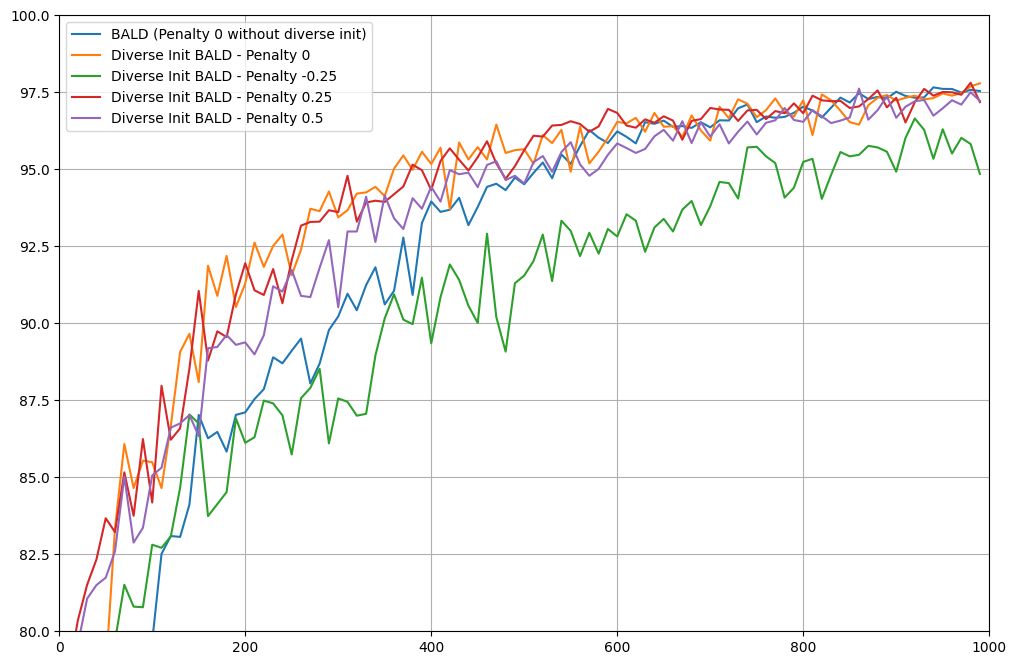

In [86]:
x_values = [i * POINTS_PER_ACQUISITION for i in range(ACQUISITION_STEPS)]
plt.figure(figsize=(12, 8))

plt.plot(x_values, results["BALD"]*100, label=f"BALD (Penalty 0 without diverse init)")
for i, accuracies in enumerate(BALD_diverse_penalties_results):
    plt.plot(x_values, accuracies[0]*100, label=f"Diverse Init BALD - Penalty {BALD_diverse_penalties[i]}")

plt.ylim(80,100)
plt.xlim(0,1000)
plt.legend()
plt.grid(True)
plt.savefig("diverse_comparison.png")
plt.show()

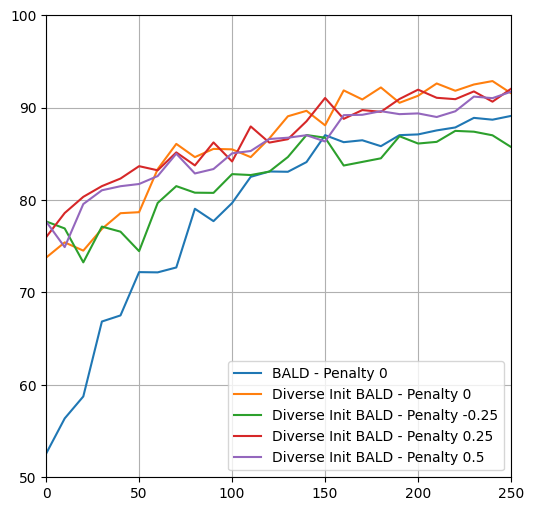

In [78]:
plt.figure(figsize=(6,6))

plt.plot(x_values, results["BALD"]*100, label=f"BALD - Penalty 0")
for i, accuracies in enumerate(BALD_diverse_penalties_results):
    plt.plot(x_values, accuracies[0]*100, label=f"Diverse Init BALD - Penalty {BALD_diverse_penalties[i]}")

plt.ylim(50,100)
plt.xlim(0,250)
plt.legend()
plt.grid(True)
plt.savefig("diverse_comparison.png")
plt.show()

Here, the first thing we see is how our unsupervised learning initialisation approach gives us a vast advantage. We see about a +20% overall improvement on accuracy in the initial training.

In addition, we confirm our intuition about the importance of diversity, even if the results are less pronounced that what we hoped. We do see that at the very start, giving a small priority to more diverse samples increases performance by about 5% up until the fifth acquisition steps. After this point, the advantage disappears quickly and can even become prohibitive for overly large penalties.

### Memory Copy (to avoid rerunning all at once)

In [72]:
BALD_diverse_penalties_results = [np.array([[0.7377, 0.7542, 0.7453, 0.7688, 0.7858, 0.7869, 0.8335, 0.8608, # Penalty = 0
         0.8465, 0.8554, 0.8549, 0.8465, 0.8667, 0.8907, 0.8966, 0.8809,
         0.9187, 0.9089, 0.9219, 0.9053, 0.9129, 0.9262, 0.9183, 0.9251,
         0.9288, 0.9156, 0.9239, 0.9372, 0.9364, 0.9428, 0.9344, 0.9367,
         0.9421, 0.9425, 0.9443, 0.9413, 0.9502, 0.9545, 0.9498, 0.9557,
         0.9517, 0.957 , 0.9371, 0.9587, 0.9532, 0.9572, 0.9532, 0.9645,
         0.9553, 0.9562, 0.9565, 0.9518, 0.9611, 0.9585, 0.9628, 0.9492,
         0.9638, 0.9519, 0.9557, 0.9602, 0.9654, 0.9649, 0.9667, 0.9622,
         0.9683, 0.9638, 0.964 , 0.9605, 0.9675, 0.9626, 0.9593, 0.9703,
         0.9666, 0.9727, 0.9713, 0.9669, 0.9692, 0.973 , 0.9685, 0.9671,
         0.9724, 0.9611, 0.9743, 0.9724, 0.969 , 0.9653, 0.9645, 0.9708,
         0.9732, 0.9741, 0.9723, 0.9732, 0.9739, 0.9727, 0.9731, 0.9746,
         0.9739, 0.9747, 0.9769, 0.9779]]),
 np.array([[0.7769, 0.7693, 0.7326, 0.7713, 0.7658, 0.7447, 0.7969, 0.8151, # Penalty = -0.25
         0.808 , 0.8078, 0.8281, 0.8271, 0.8308, 0.8466, 0.8704, 0.8675,
         0.8374, 0.8413, 0.8452, 0.8691, 0.8612, 0.863 , 0.8749, 0.874 ,
         0.8701, 0.8574, 0.8757, 0.879 , 0.8852, 0.861 , 0.8756, 0.8745,
         0.87  , 0.8706, 0.8896, 0.9016, 0.9094, 0.9012, 0.8997, 0.9148,
         0.8935, 0.9085, 0.9191, 0.9141, 0.9057, 0.9001, 0.9291, 0.902 ,
         0.8908, 0.913 , 0.9155, 0.9202, 0.9288, 0.9137, 0.9333, 0.93  ,
         0.9218, 0.9294, 0.9226, 0.9306, 0.9282, 0.9354, 0.9333, 0.9232,
         0.9311, 0.9339, 0.9298, 0.9369, 0.9397, 0.9319, 0.938 , 0.9459,
         0.9455, 0.9405, 0.9571, 0.9573, 0.9542, 0.952 , 0.9408, 0.944 ,
         0.9524, 0.9534, 0.9404, 0.9482, 0.9556, 0.9542, 0.9547, 0.9576,
         0.9571, 0.9557, 0.9492, 0.9602, 0.9665, 0.9628, 0.9534, 0.963 ,
         0.9551, 0.9602, 0.9582, 0.9485]]),
 np.array([[0.7598, 0.786 , 0.8035, 0.8151, 0.8233, 0.8367, 0.8322, 0.8516, # Penalty = 0.25
         0.8375, 0.8624, 0.8418, 0.8797, 0.8622, 0.8659, 0.8853, 0.9105,
         0.8879, 0.8974, 0.8955, 0.9094, 0.9195, 0.9107, 0.9092, 0.9176,
         0.9065, 0.9205, 0.9317, 0.9329, 0.933 , 0.9367, 0.9361, 0.9479,
         0.933 , 0.9392, 0.9398, 0.9394, 0.9419, 0.9444, 0.9515, 0.9497,
         0.9433, 0.9527, 0.9568, 0.9531, 0.9496, 0.9539, 0.9591, 0.9519,
         0.9469, 0.951 , 0.9562, 0.9609, 0.9606, 0.9642, 0.9644, 0.9656,
         0.9647, 0.9622, 0.9639, 0.9696, 0.9683, 0.9642, 0.9635, 0.9662,
         0.9651, 0.9672, 0.9658, 0.9596, 0.9657, 0.9663, 0.9699, 0.9694,
         0.9693, 0.9657, 0.9691, 0.9693, 0.9663, 0.9689, 0.9682, 0.9714,
         0.9682, 0.9739, 0.9724, 0.9721, 0.9722, 0.9699, 0.9704, 0.9728,
         0.9756, 0.9701, 0.9732, 0.9652, 0.9718, 0.9761, 0.9739, 0.9751,
         0.975 , 0.9742, 0.9781, 0.9718]]),
 np.array([[0.7768, 0.7491, 0.7957, 0.8106, 0.815 , 0.8174, 0.826 , 0.8502,
         0.8288, 0.8336, 0.8506, 0.8531, 0.8661, 0.8675, 0.8702, 0.8634,
         0.8919, 0.8923, 0.8962, 0.893 , 0.8938, 0.8899, 0.8961, 0.912 ,
         0.9103, 0.9173, 0.9089, 0.9085, 0.918 , 0.927 , 0.9052, 0.9298,
         0.9298, 0.9411, 0.9264, 0.9415, 0.9341, 0.9306, 0.9406, 0.9372,
         0.9443, 0.9395, 0.9497, 0.9484, 0.9489, 0.9442, 0.9514, 0.9526,
         0.9465, 0.9479, 0.9454, 0.9523, 0.9543, 0.9492, 0.9556, 0.9588,
         0.9516, 0.9479, 0.9501, 0.9547, 0.9584, 0.9569, 0.9553, 0.9566,
         0.9607, 0.9628, 0.9593, 0.9656, 0.9585, 0.9653, 0.9606, 0.9646,
         0.9584, 0.9622, 0.9655, 0.9613, 0.9651, 0.9659, 0.9699, 0.966 ,
         0.9654, 0.9692, 0.9672, 0.965 , 0.9658, 0.9668, 0.9762, 0.9661,
         0.9692, 0.9737, 0.9667, 0.9703, 0.9721, 0.9725, 0.9674, 0.9698,
         0.9724, 0.971 , 0.975 , 0.9722]])]